# <font color='orange'>Step 2: Data Understanding</font> 

In [1]:
# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
#pyspark
import pyspark
from pyspark.sql import SparkSession
import warnings
warnings.simplefilter(action='ignore')
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf



# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer

In [2]:
# # Findspark can add a startup file to the current IPython profile so that the environment vaiables will 
# # be properly set and pyspark will be imported upon IPython startup
# import findspark
# findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

In [3]:
# Build a sparksession and build a unique app name
spark=SparkSession.builder.appName('iteration-4: prediction_hospital_readmission_rate ').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/12 08:15:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

## <font color='grey'> 2.1: Collect Initial Data</font> 

In [5]:
# Read the data from csv file into a dataframe
diabetic_data=spark.read.option("header","true").csv('Dataset/diabetic_data.csv')

## <font color='grey'> 2.2: Data Description</font> 

In [6]:
diabetic_data.show()

22/10/12 08:15:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [7]:
# diabetic_data.toPandas().head()

## <font color='grey'> 2.3: Explore the Data</font> 

In [8]:
# Check number of rows and columns in the data
row=diabetic_data.count()
cols=len(diabetic_data.columns)
print('Total number of columns are - ', cols)
print('\nTotal number of records are - ', row)

Total number of columns are -  50

Total number of records are -  101766


In [9]:
diabetic_data.select('readmitted').groupBy('readmitted').count().sort(col('count').asc()).show()

+----------+-----+
|readmitted|count|
+----------+-----+
|       <30|11357|
|       >30|35545|
|        NO|54864|
+----------+-----+



In [10]:
diabetic_data.printSchema()

root
 |-- encounter_id: string (nullable = true)
 |-- patient_nbr: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: string (nullable = true)
 |-- discharge_disposition_id: string (nullable = true)
 |-- admission_source_id: string (nullable = true)
 |-- time_in_hospital: string (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: string (nullable = true)
 |-- num_procedures: string (nullable = true)
 |-- num_medications: string (nullable = true)
 |-- number_outpatient: string (nullable = true)
 |-- number_emergency: string (nullable = true)
 |-- number_inpatient: string (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: string (nullable = true)
 |-- max_glu_ser

In [11]:
# Let's import in the relevant types.
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,FloatType)


In [12]:
# Then create a variable with the correct structure.
data_schema = [StructField('encounter_id',IntegerType(),True),
              StructField('patient_nbr',IntegerType(),True),
              StructField('race',StringType(),True),
              StructField('gender',StringType(),True),
              StructField('age',StringType(),True),
              StructField('weight',StringType(),True),
              StructField('admission_type_id',IntegerType(),True),
              StructField('discharge_disposition_id',IntegerType(),True),
              StructField('admission_source_id',IntegerType(),True),
              StructField('time_in_hospital',IntegerType(),True),
              StructField('payer_code',StringType(),True),
              StructField('medical_specialty',StringType(),True),
              StructField('num_lab_procedures',IntegerType(),True),
              StructField('num_procedures',IntegerType(),True),
              StructField('num_medications',IntegerType(),True),
              StructField('number_outpatient',IntegerType(),True),
              StructField('number_emergency',IntegerType(),True),
              StructField('number_inpatient',IntegerType(),True),
              StructField('diag_1',StringType(),True),
              StructField('diag_2',StringType(),True),
              StructField('diag_3',StringType(),True),
              StructField('number_diagnoses',IntegerType(),True),
              StructField('max_glu_serum',StringType(),True),
              StructField('A1Cresult',StringType(),True),
              StructField('metformin',StringType(),True),
              StructField('repaglinide',StringType(),True),
              StructField('nateglinide',StringType(),True),
              StructField('chlorpropamide',StringType(),True),
              StructField('glimepiride',StringType(),True),
              StructField('acetohexamide',StringType(),True),
              StructField('glipizide',StringType(),True),
              StructField('glyburide',StringType(),True),
              StructField('tolbutamide',StringType(),True),
              StructField('pioglitazone',StringType(),True),
              StructField('rosiglitazone',StringType(),True),
              StructField('acarbose',StringType(),True),
              StructField('miglitol',StringType(),True),
              StructField('troglitazone',StringType(),True),
              StructField('tolazamide',StringType(),True),
              StructField('examide',StringType(),True),
              StructField('citoglipton',StringType(),True),
              StructField('insulin',StringType(),True),
              StructField('glyburide-metformin',StringType(),True),
              StructField('glipizide-metformin',StringType(),True),
              StructField('glimepiride-pioglitazone',StringType(),True),
              StructField('metformin-rosiglitazone',StringType(),True),
              StructField('metformin-pioglitazone',StringType(),True),
              StructField('change',StringType(),True),
              StructField('diabetesMed',StringType(),True),
              StructField('readmitted',StringType(),True)]

final_struct = StructType(fields=data_schema)

In [13]:
diabetic_data=spark.read.option("header","true").csv('Dataset/diabetic_data.csv',schema=final_struct)

In [14]:
diabetic_data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

In [15]:
# Seperate two object for continuous and categorical data
numeric_columns = [column[0] for column in diabetic_data.dtypes if column[1]=='int']
categorical_data=[column[0] for column in diabetic_data.dtypes if column[1]=='string']

In [16]:
# n=[]
# for col in diabetic_data.dtypes:
#     if col[1]=='int':
#         n.append(col[0])
# n

    

## Pyspark SQL

In [17]:
# First, we have to register the DataFrame as a SQL temporary view.
diabetic_data.createOrReplaceTempView('diabetic_data')

# After that, we can use the SQL programming language for queries. 
results = spark.sql("SELECT * FROM diabetic_data")
results.show()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [18]:
spark.sql("select distinct race from diabetic_data").show()

+---------------+
|           race|
+---------------+
|      Caucasian|
|          Other|
|AfricanAmerican|
|       Hispanic|
|          Asian|
|              ?|
+---------------+



In [19]:
spark.sql("select distinct gender from diabetic_data").show()

+---------------+
|         gender|
+---------------+
|         Female|
|Unknown/Invalid|
|           Male|
+---------------+



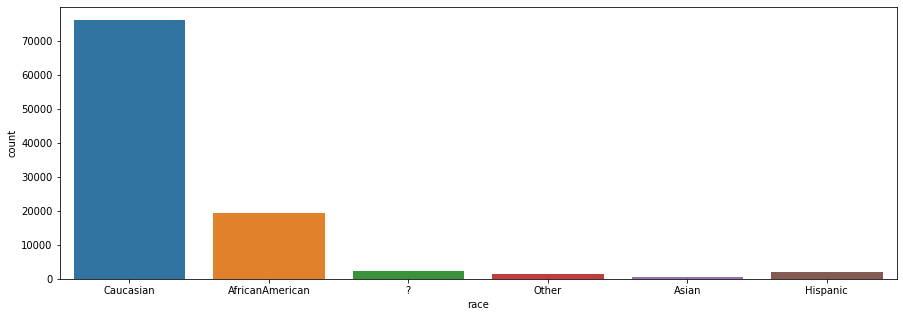

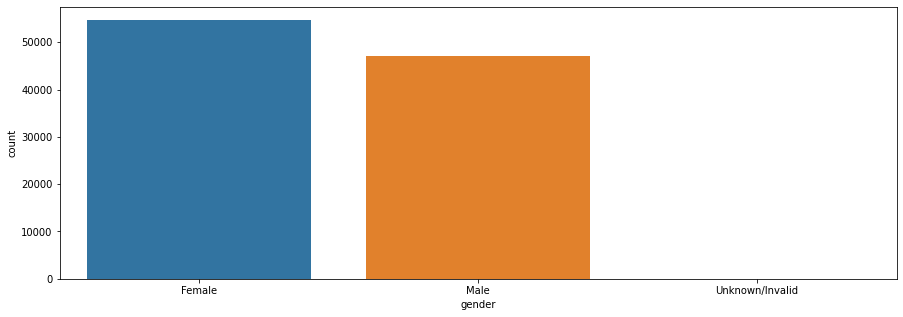

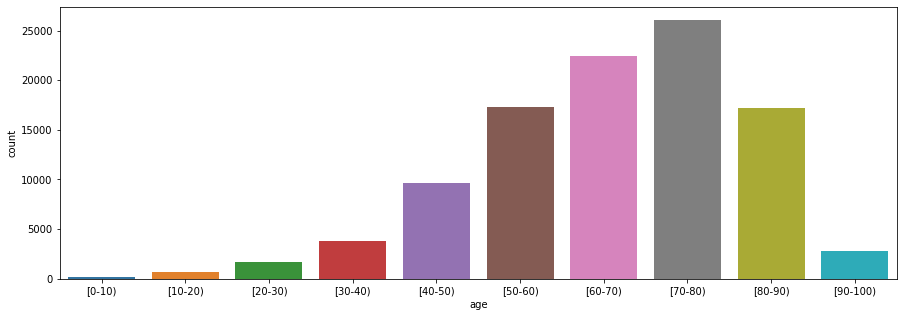

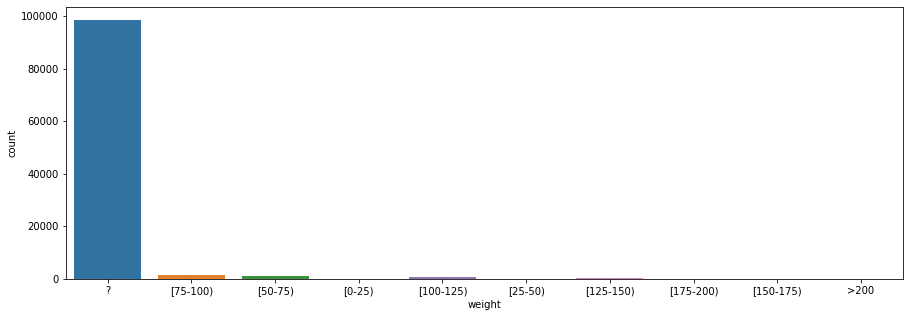

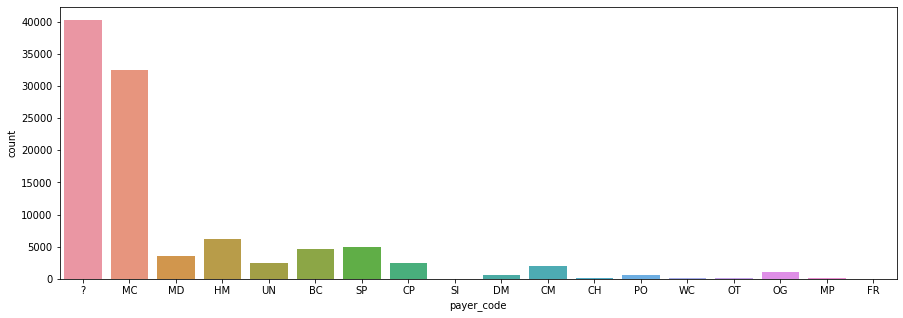

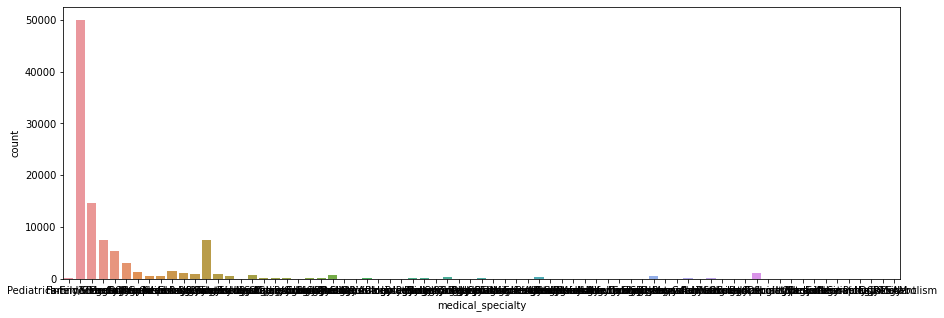

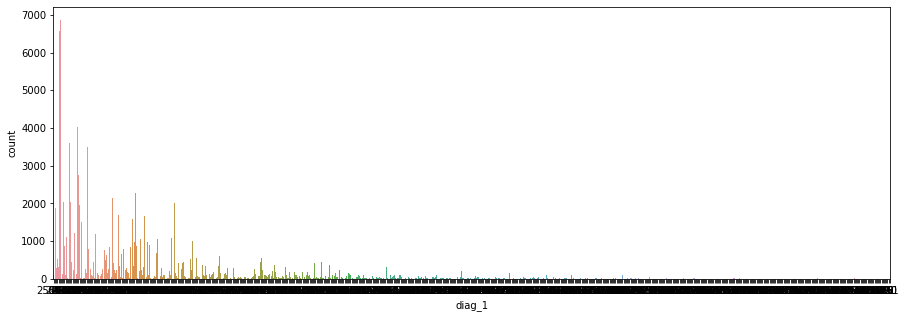

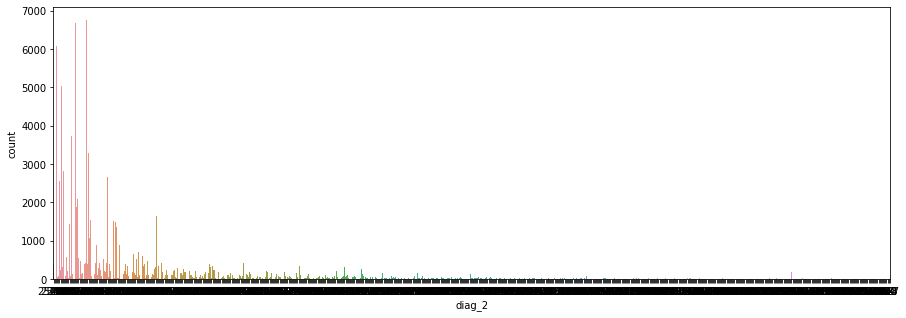

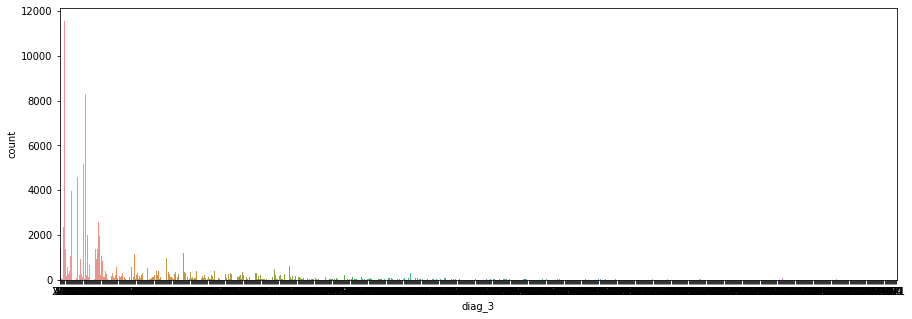

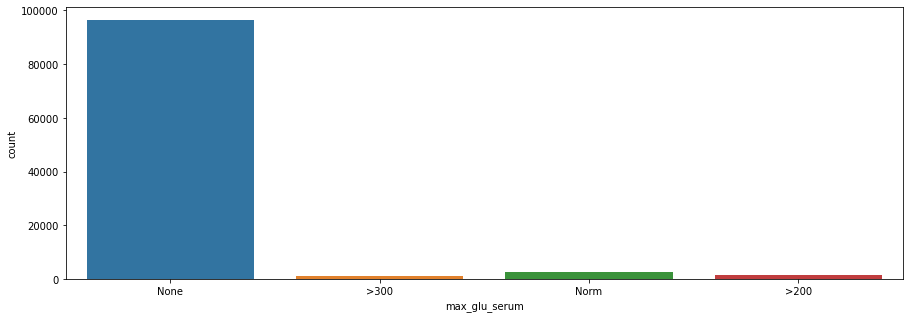

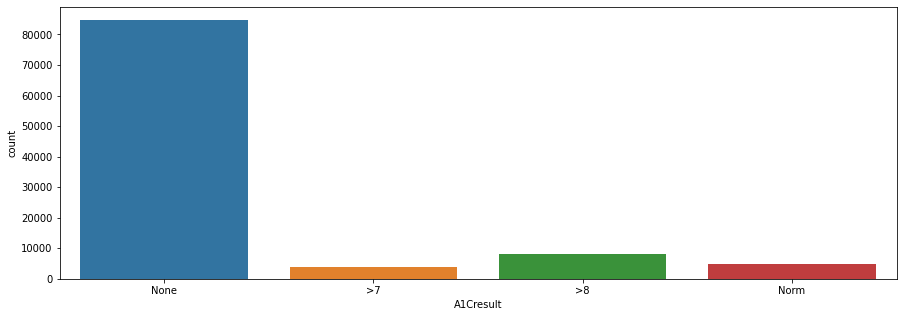

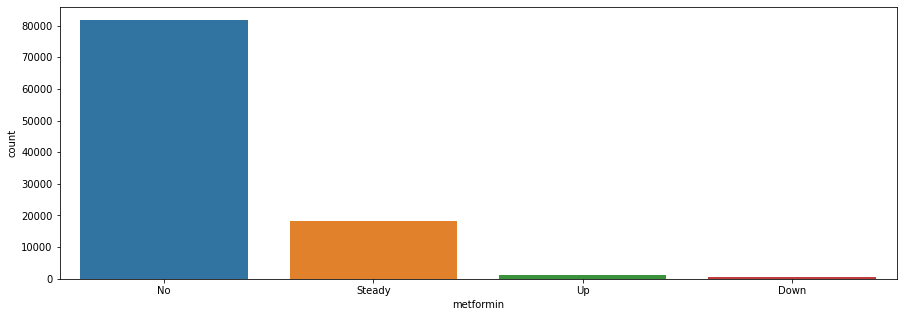

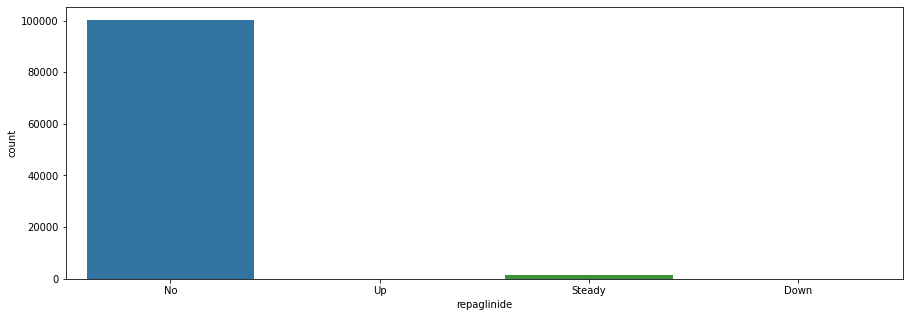

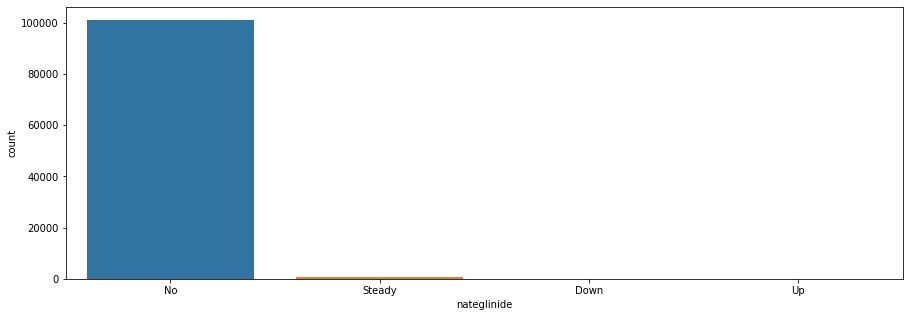

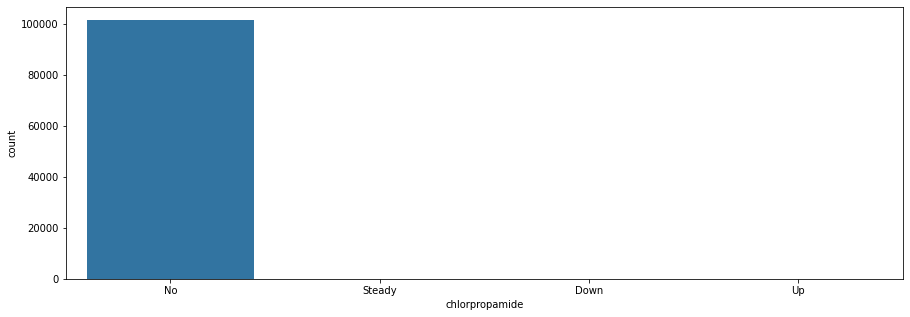

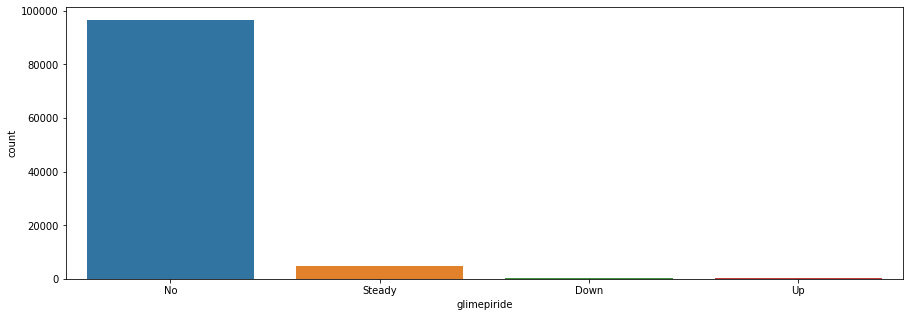

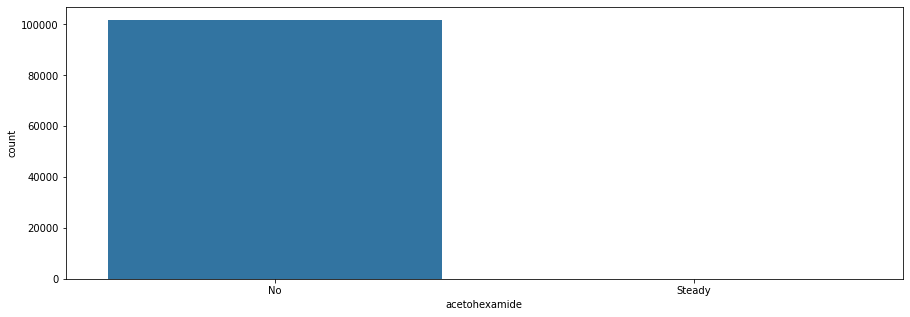

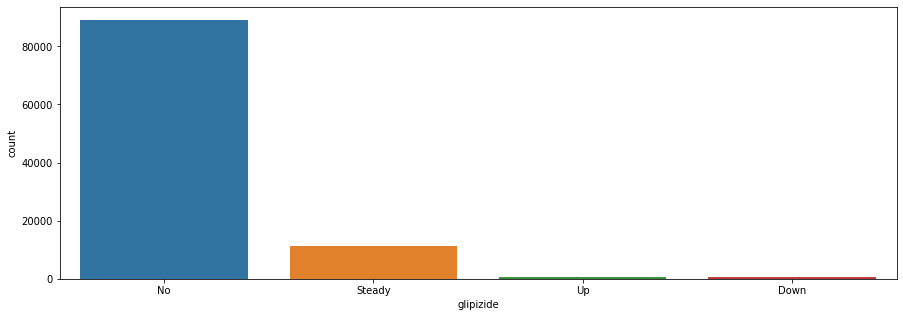

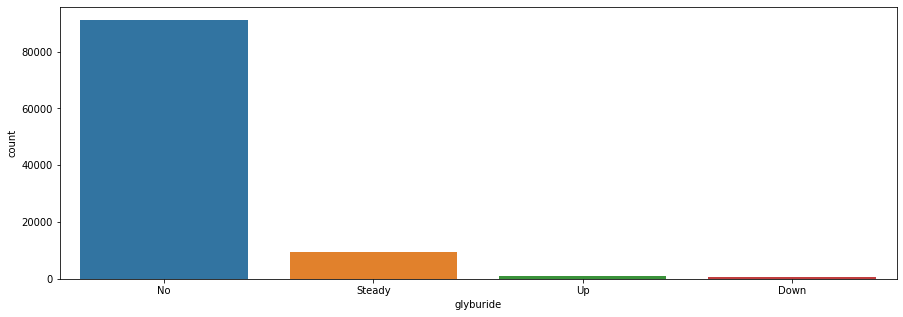

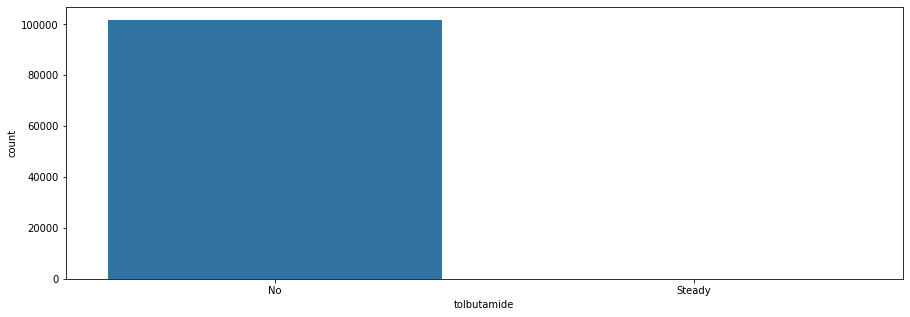

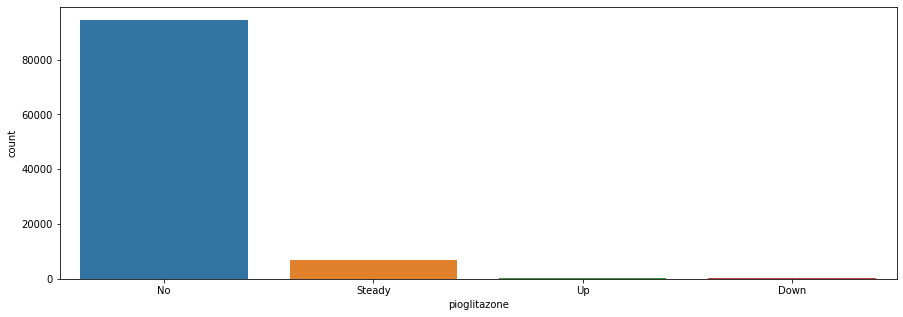

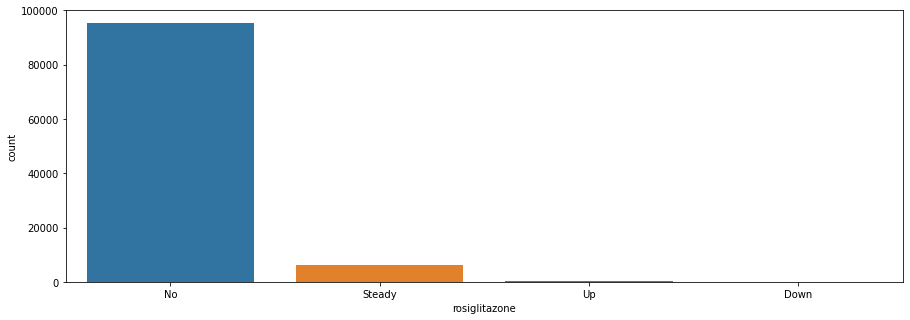

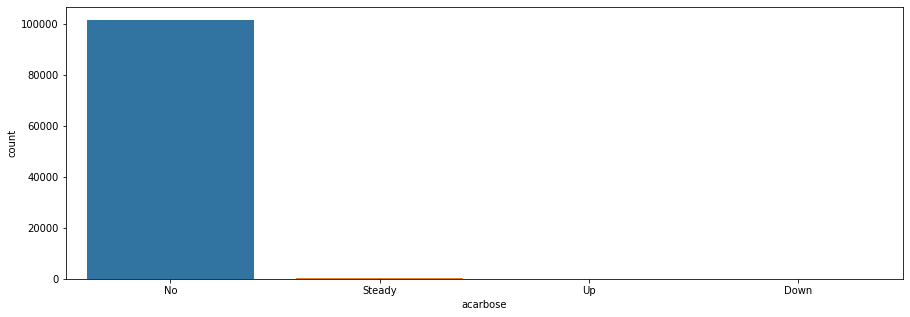

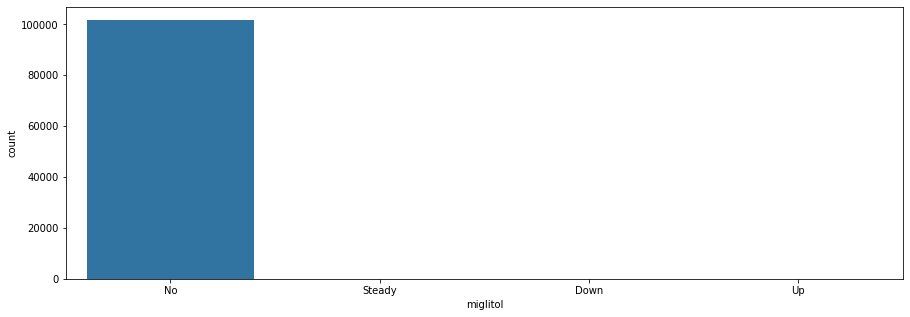

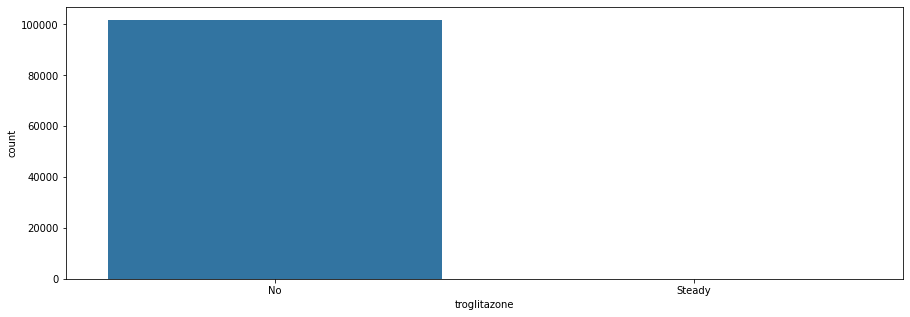

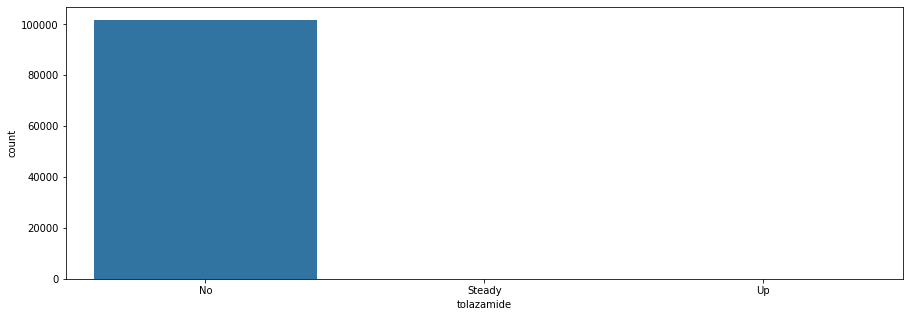

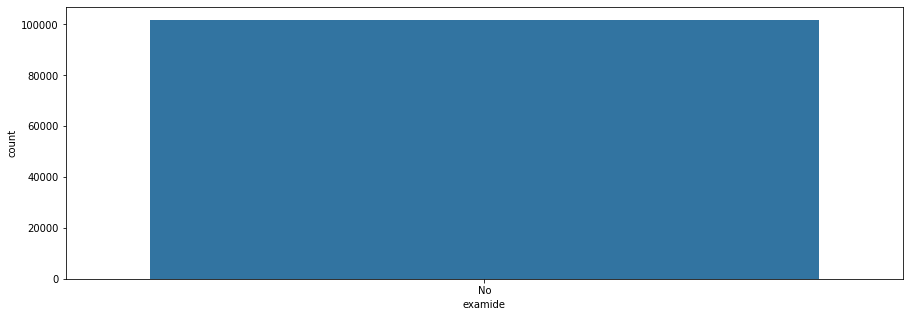

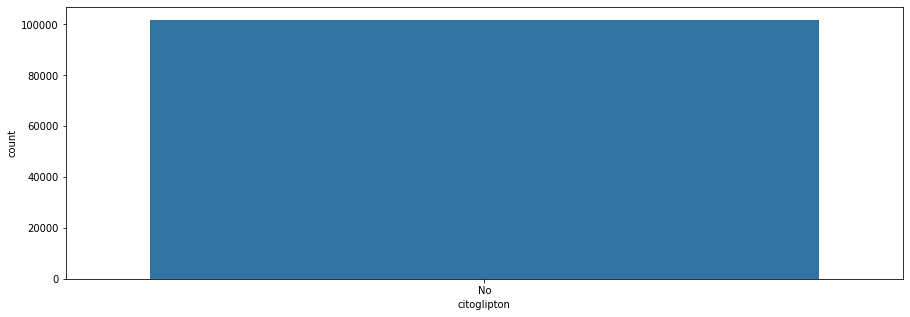

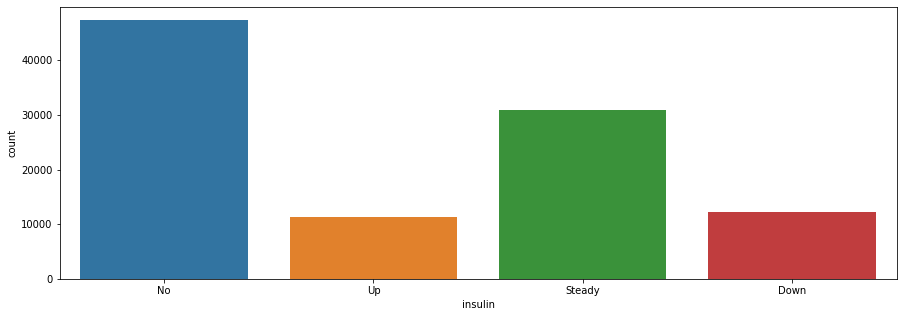

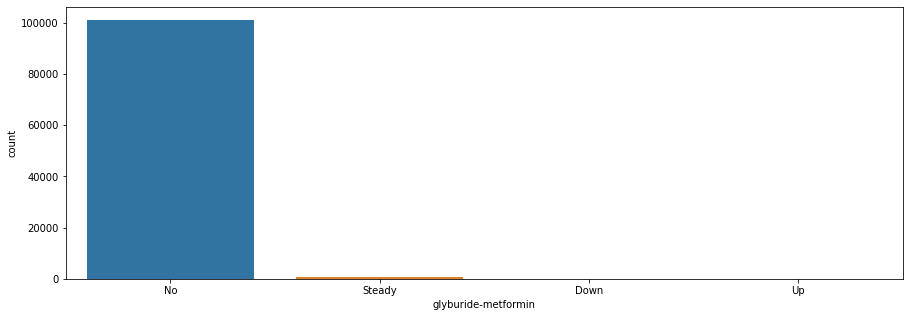

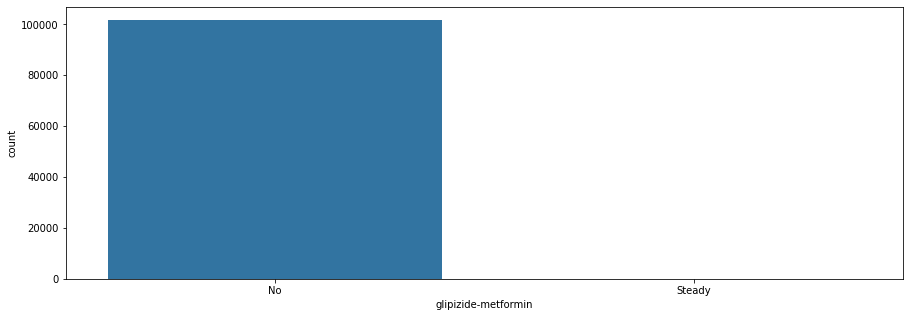

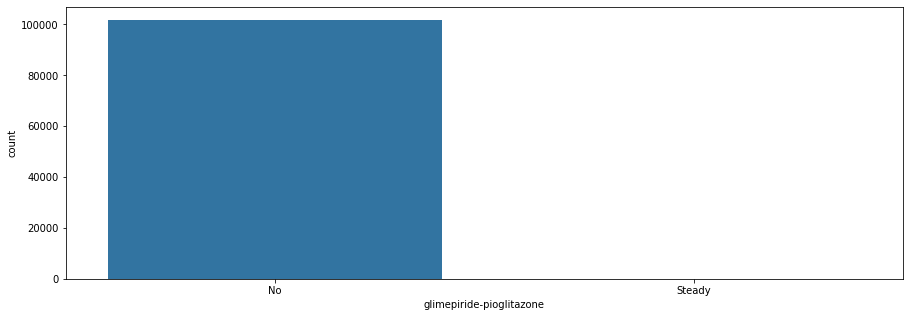

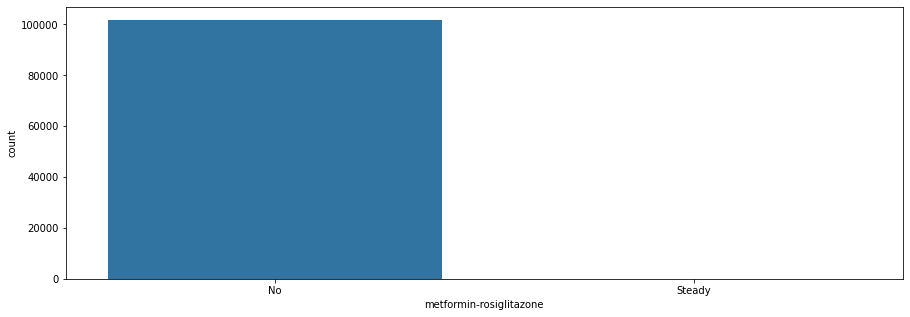

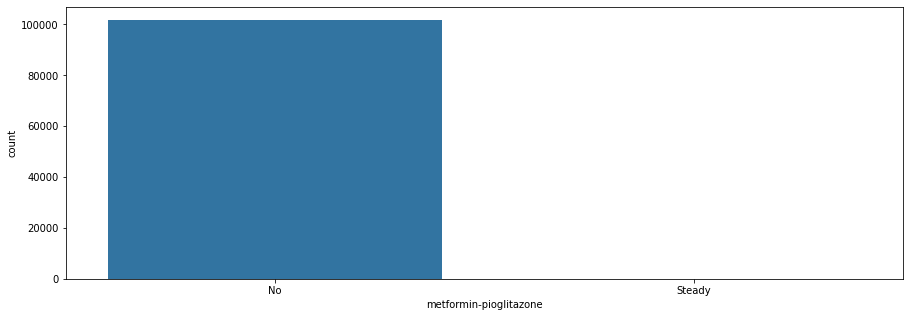

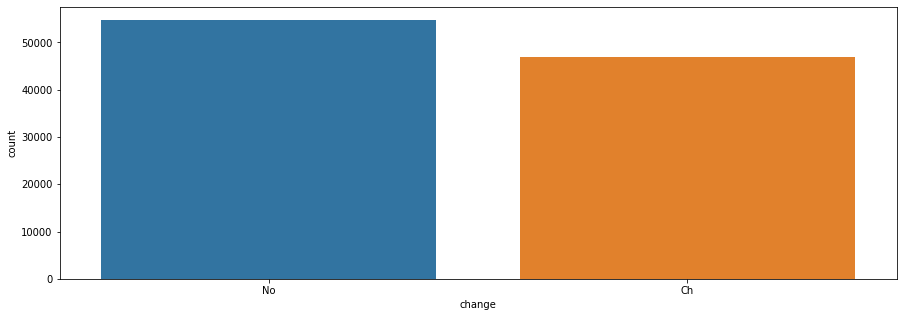

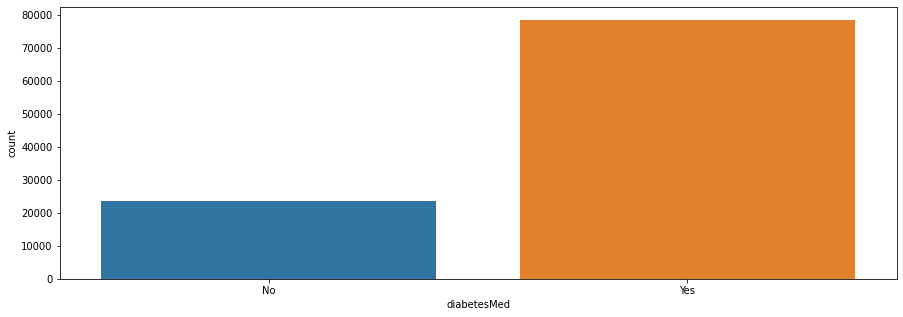

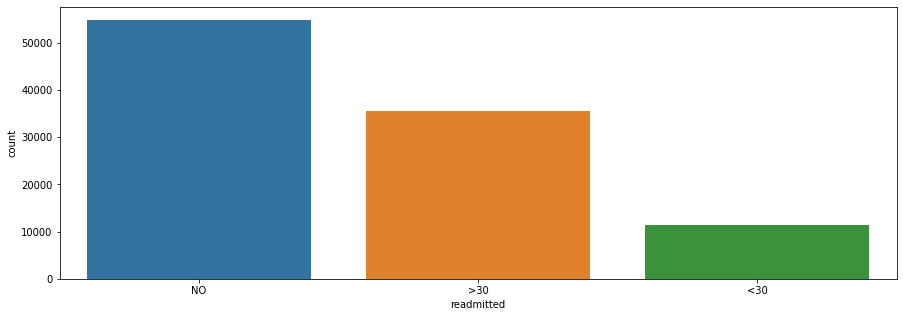

In [20]:
def countplot(df):
    for col in categorical_data:
        plt.figure(figsize=(15,5))
        sns.countplot(data=(diabetic_data.select(col).toPandas()), x=col)
        plt.show()
countplot(diabetic_data)
        

In [21]:
# sns.countplot(data=(diabetic_data.select('readmitted').toPandas()), x='readmitted')

In [22]:
from pyspark.sql.functions import when
df3 = diabetic_data.withColumn("readmitted", when(diabetic_data.readmitted == "NO",0) \
      .when(diabetic_data.readmitted == ">30",1).when(diabetic_data.readmitted == "<30",2) \
      .otherwise(diabetic_data.readmitted))
# change the readmitted data types from string to integar after changing the values in new data frame, just for the 
#viaualization purpose
df3=df3.withColumn("readmitted",df3.readmitted.cast(IntegerType()))


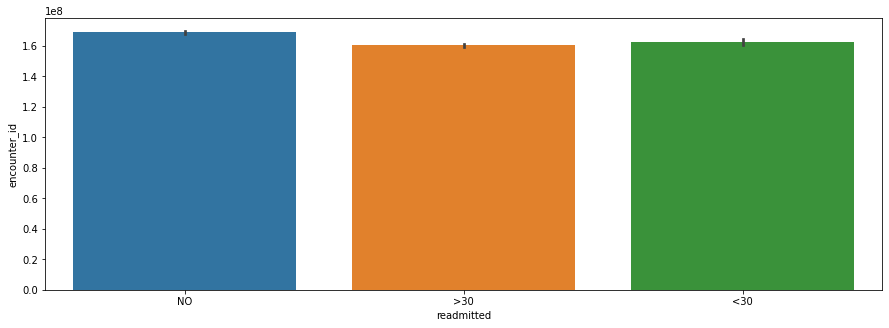

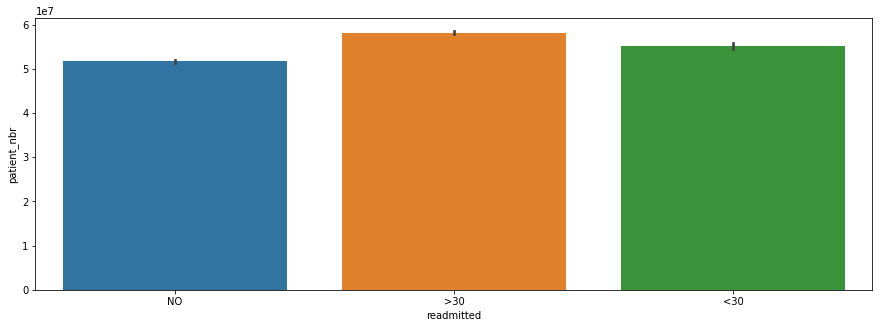

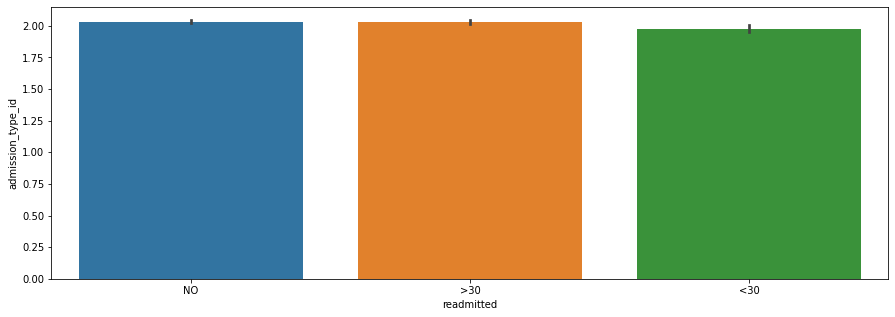

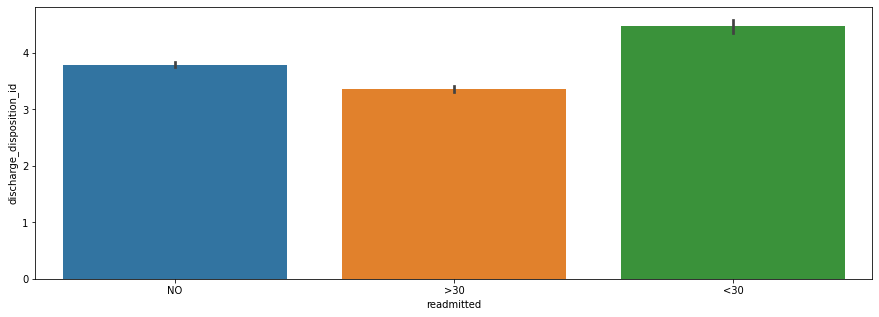

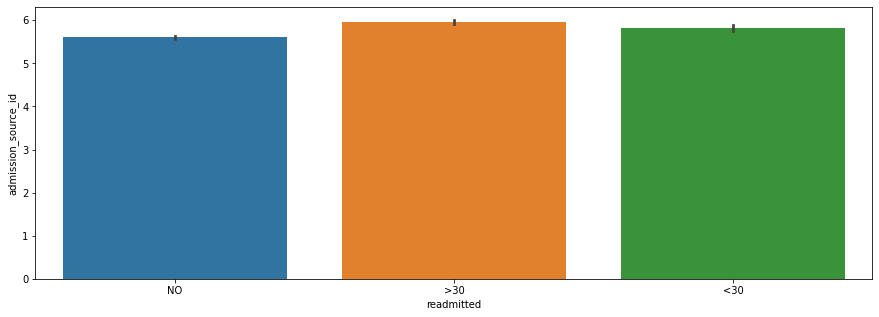

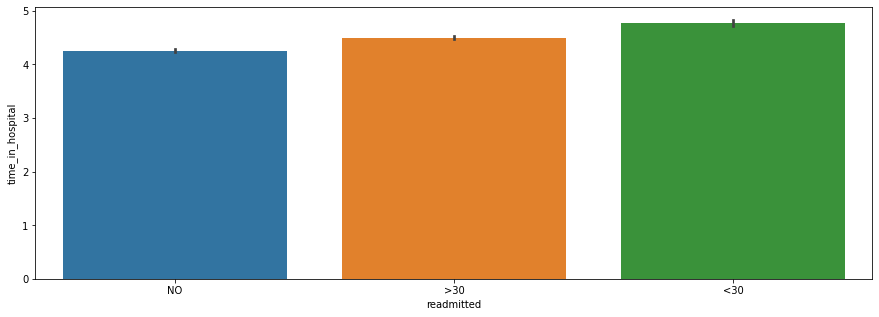

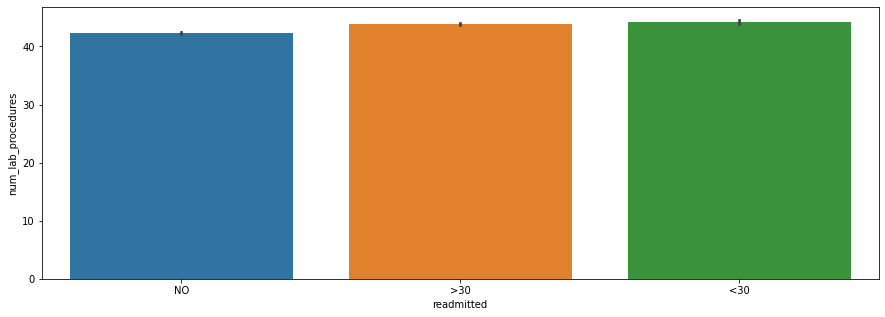

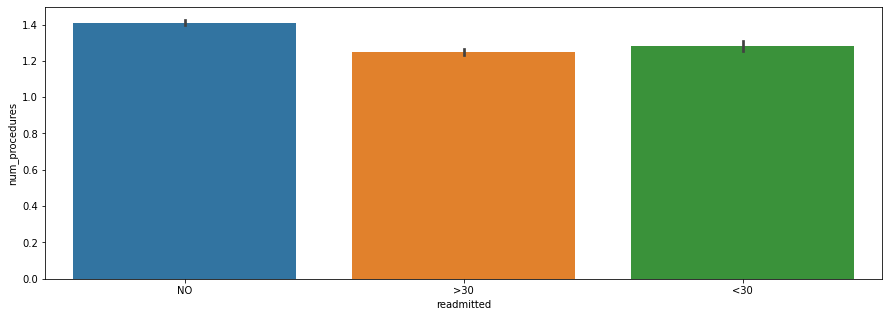

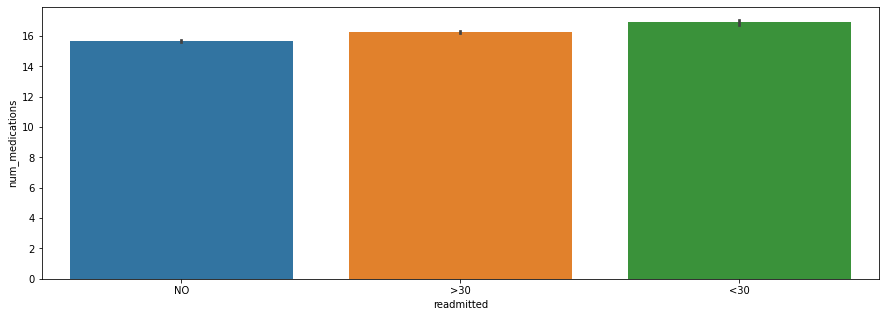

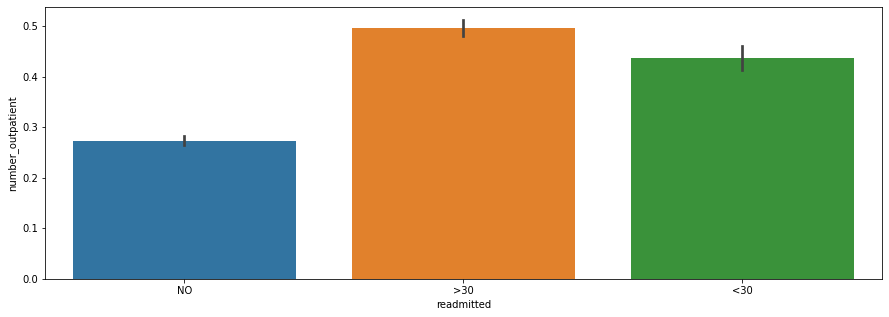

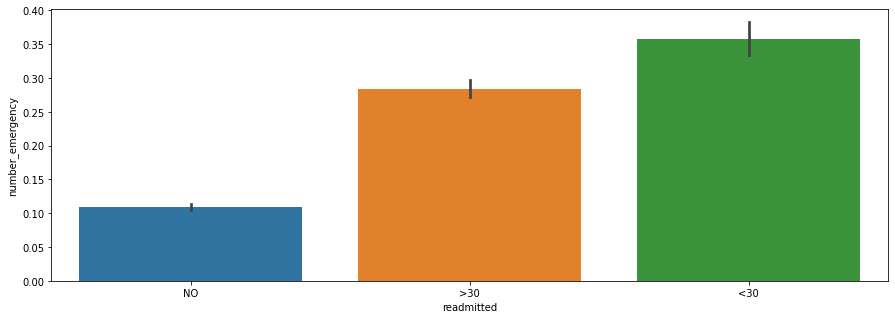

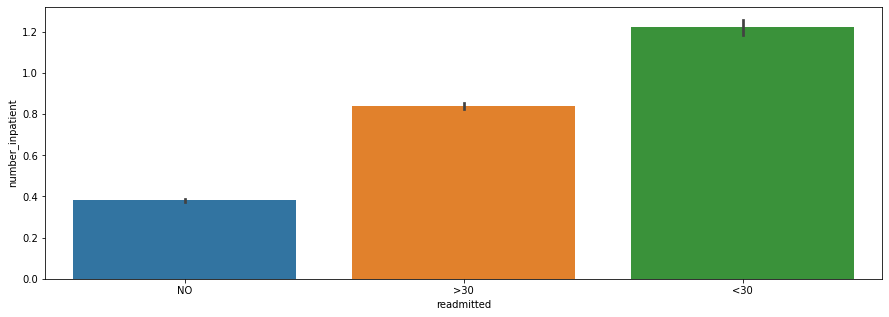

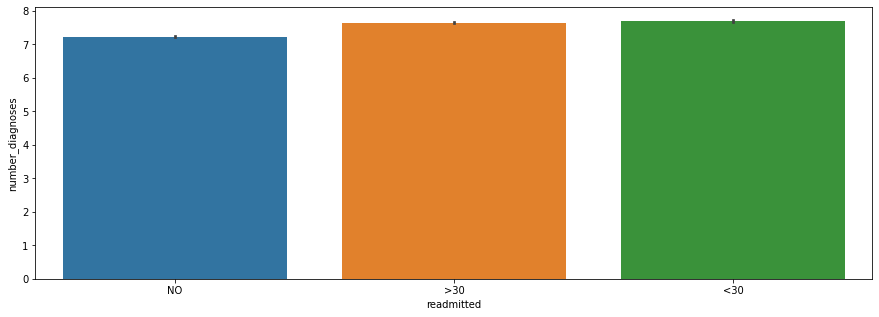

In [23]:

def barplot(df):
    for col in numeric_columns:
        plt.figure(figsize=(15,5))
        sns.barplot(data=(df.toPandas()), y=col,x='readmitted')
        plt.show()
barplot(diabetic_data)

In [24]:
def histogram(df):
    for col in numeric_columns:
        plt.figure(figsize=(15,5))
        plt.hist(data=(diabetic_data.select(col).toPandas()),x=col,bins=15, color='b')
        plt.title(col)
        plt.show()

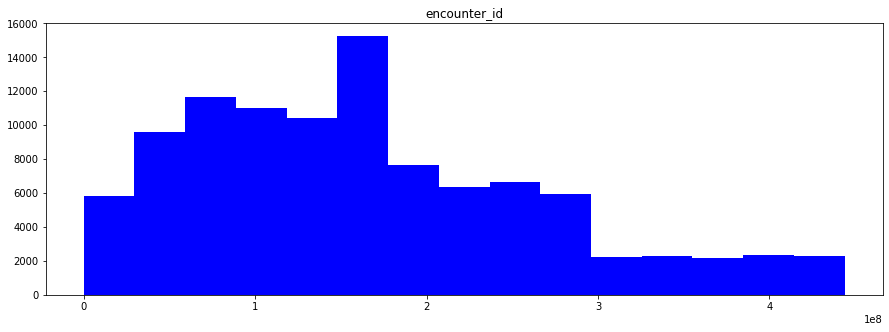

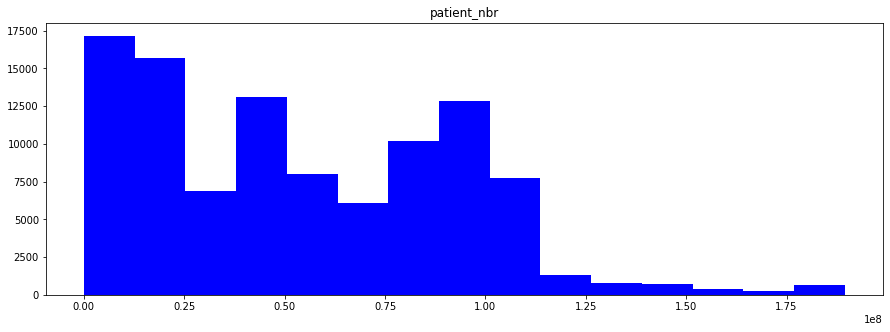

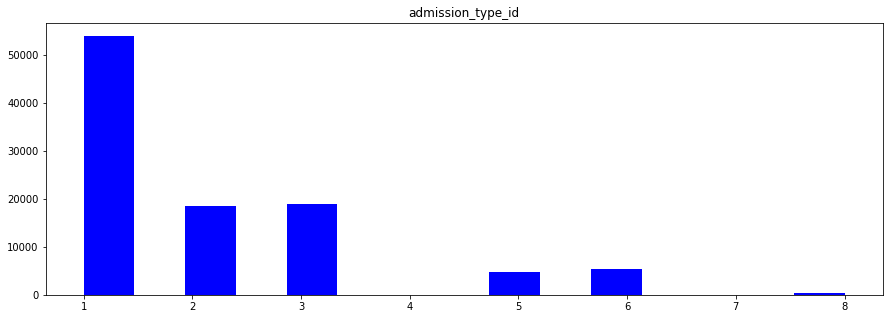

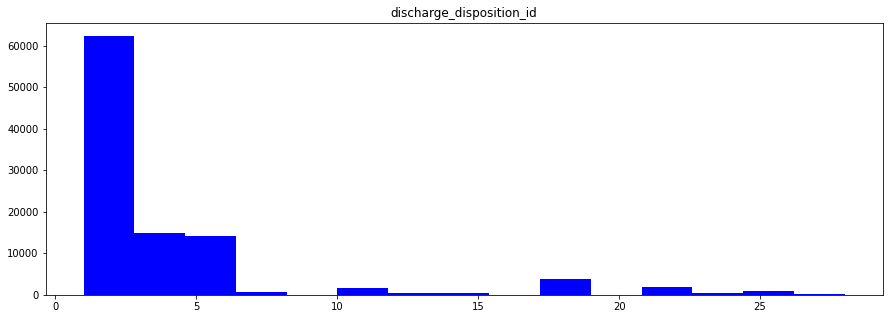

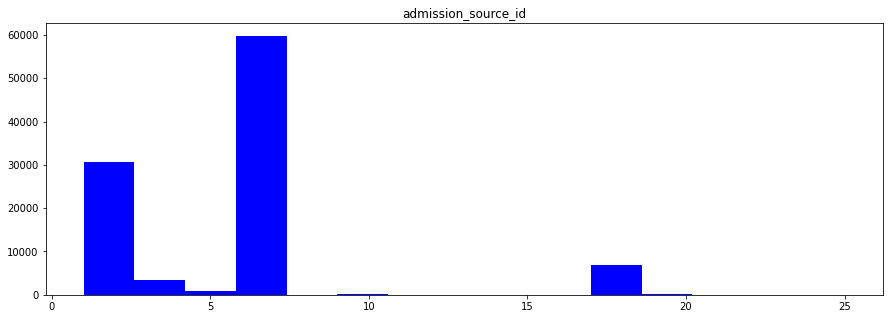

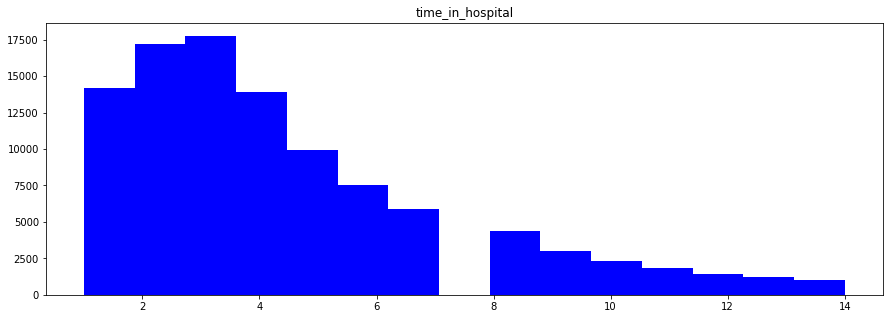

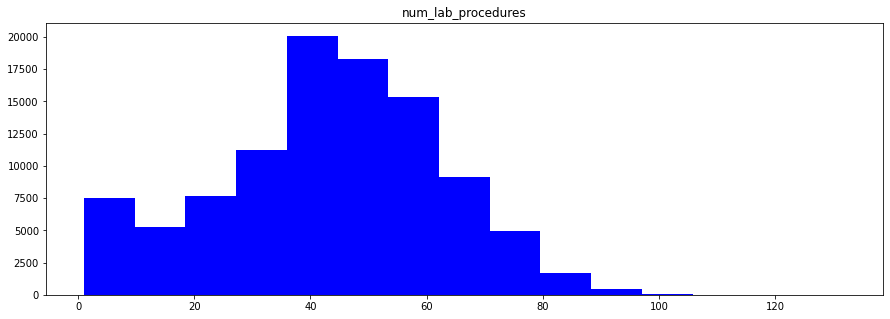

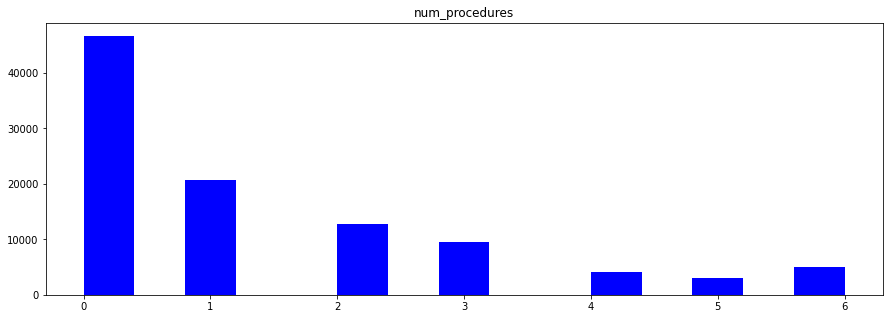

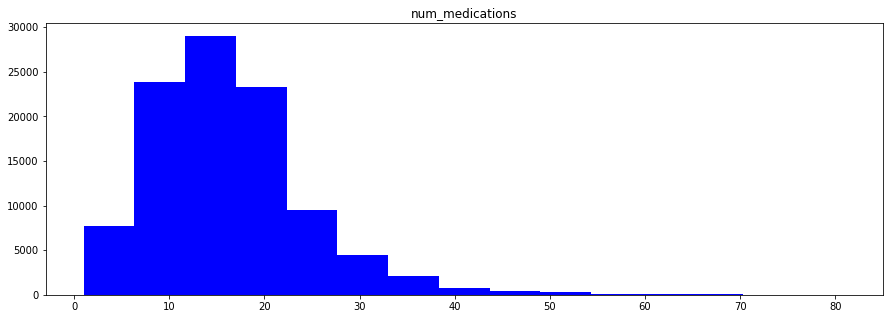

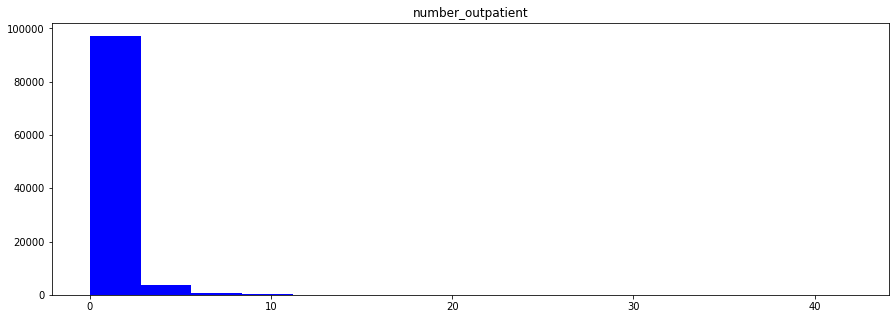

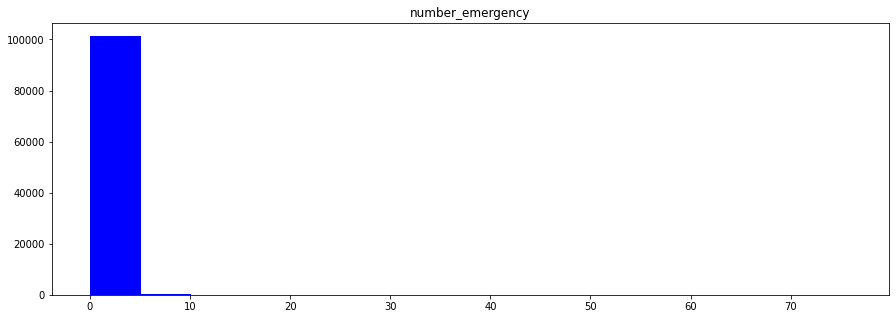

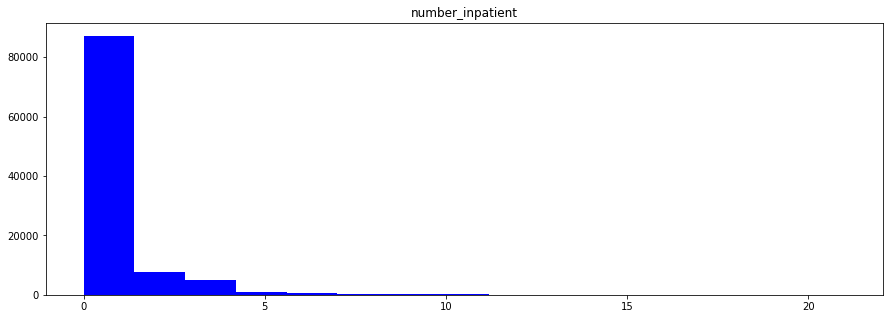

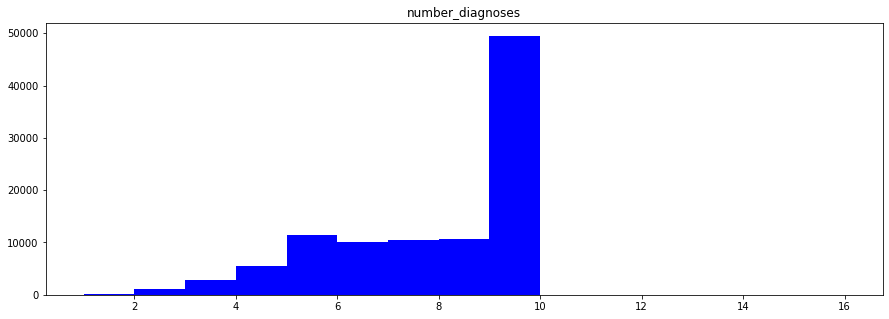

In [25]:
histogram(diabetic_data)

In [26]:

# sns.barplot(data=(diabetic_data.select('number_emergency','readmitted').filter("number_emergency<=1").toPandas()), y='number_emergency',x='readmitted')

In [27]:

# sns.barplot(data=(diabetic_data.select('number_emergency','readmitted').filter("number_emergency>1").toPandas()), y='number_emergency',x='readmitted')

## <font color='grey'> 2.4: Data Quality</font> 

### Check Missing Values

In [28]:
# Using List comprehension, we will check the mising values in the data
from pyspark.sql.functions import col,isnan,when,count
df1 = diabetic_data.select([count(when(col(c).contains('Nan') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns])
df1.show()

#looks like data is clean but has missing values with "?" sign

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [29]:
# check how many columns has contained "?" sign with how many values
from pyspark.sql.functions import col,isnan,when,count
df2 = diabetic_data.select([count(when(col(c).contains('?') | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns])
df2.show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [30]:
# # Now We will check the missing values in the data
# # Using List comprehension, we will check the mising values in the data
# df3 = diabetic_data.select([count(when(col(c).contains('Nan') | \
#                             col(c).contains('NULL') | \
#                             (col(c) == '' ) | (col(c) == '?' )| \
#                             col(c).isNull() | \
#                             isnan(c), c 
#                            )).alias(c)
#                     for c in diabetic_data.columns])
# df3.show()

In [31]:
# # numeric_cols=diabetic_data.
# diabetic_data.race.show()

In [32]:
# diabetic_data.select('time_in_hospital').approxQuantile(probabilities=[0.25],relativeError=0)

In [33]:
# q1=diabetic_data.approxQuantile('time_in_hospital',[0.25],relativeError=0)

In [34]:
# IQR=q3[0]-q1[0]
# IQR

## <font color='grey'> 2.4: Data Quality</font> 

In [35]:
# from pyspark.sql import functions as f
# def find_outliers(df):

#     # Identifying the numerical columns in a spark dataframe
#     numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

#     # Using the `for` loop to create new columns by identifying the outliers for each feature
#     for column in numeric_columns:

#         less_Q1 = 'less_Q1_{}'.format(column)
#         more_Q3 = 'more_Q3_{}'.format(column)
#         Q1 = 'Q1_{}'.format(column)
#         Q3 = 'Q3_{}'.format(column)

#         # Q1 : First Quartile ., Q3 : Third Quartile
#         Q1 = df.approxQuantile(column,[0.25],relativeError=0)
#         Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
#         # IQR : Inter Quantile Range
#         # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
#         # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
#         IQR = Q3[0] - Q1[0]
        
#         #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
#         less_Q1 =  Q1[0] - 1.5*IQR
#         more_Q3 =  Q3[0] + 1.5*IQR
        
#         isOutlierCol = 'is_outlier_{}'.format(column)
        
#         df_1=df.filter((df[col]<=less_Q1) | (df[col]>=more_Q3) )
# #         df_2=df.filter(df[col]>=more_Q3)
# # #         df_1=df[(df.select(col)<=lower)]
# # #         df_2=df[(df.select(col)>=upper)]
# #         df=unionAll([df_1,df_2])
# #         df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

# #     # Selecting the specific columns which we have added above, to check if there are any outliers
# #     selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

# #     # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
# #     df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

# #     # Dropping the extra columns created above, just to create nice dataframe., without extra columns
# #     df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

#     return df_1

In [36]:
# # dataframe=diabetic_data.select('total_outliers')
# x=find_outliers(diabetic_data)
# x.count()

In [37]:
# import functools
 
# # explicit function
# def unionAll(dfs):
#     return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)



In [38]:
# Finding Outlier using IQR
def finding_outlier(df,col):
#     for col in numeric_columns:
    df.select(col).toPandas().astype(int)
    q1=df.approxQuantile(col,[0.25],relativeError=0)
    q3=df.approxQuantile(col,[0.75],relativeError=0)
    IQR=q3[0]-q1[0]
    upper=q3[0]+1.5*IQR
    lower=q1[0]-1.5*IQR
    df_1=df.filter((df[col]<=lower) | (df[col]>=upper) )
#         df_1=df[(df.select(col)<=lower)]
#         df_2=df[(df.select(col)>=upper)]
#     df=unionAll([df_1,df_2])

    return df_1.select(col)

In [39]:
finding_outlier(diabetic_data,'num_medications').groupby('num_medications').count().withColumnRenamed('count','outliers').sort(('num_medications')).show()

+---------------+--------+
|num_medications|outliers|
+---------------+--------+
|             35|     388|
|             36|     287|
|             37|     293|
|             38|     228|
|             39|     209|
|             40|     179|
|             41|     146|
|             42|     128|
|             43|     127|
|             44|     100|
|             45|      88|
|             46|      92|
|             47|      74|
|             48|      60|
|             49|      61|
|             50|      55|
|             51|      43|
|             52|      54|
|             53|      40|
|             54|      33|
+---------------+--------+
only showing top 20 rows



In [40]:
# finding_outlier(diabetic_data,'num_medications').groupby('num_medications').count().withColumnRenamed('count','outliers').sort(('num_medications')).show()

In [41]:
def outlier_count():
    for col in numeric_columns:
        print(f"{col}",finding_outlier(diabetic_data,col).count())
outlier_count()

encounter_id 0
patient_nbr 247
admission_type_id 5632
discharge_disposition_id 9818
admission_source_id 6956
time_in_hospital 3700
num_lab_procedures 171
num_procedures 8032
num_medications 2945
number_outpatient 101766
number_emergency 101766
number_inpatient 7049
number_diagnoses 281


In [42]:
#checked the statistics
diabetic_data.toPandas().describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


<AxesSubplot:xlabel='num_medications'>

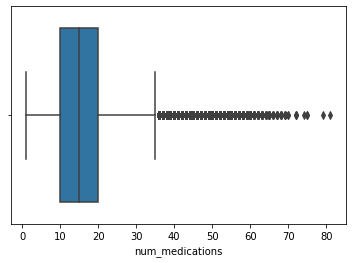

In [43]:
sns.boxplot(data=(diabetic_data.select('num_medications').toPandas()),x='num_medications')

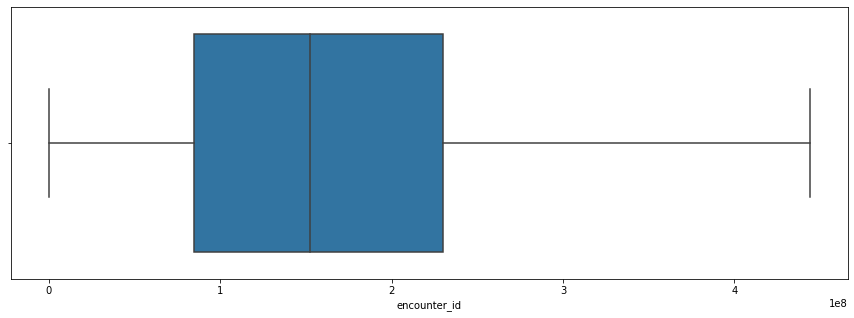

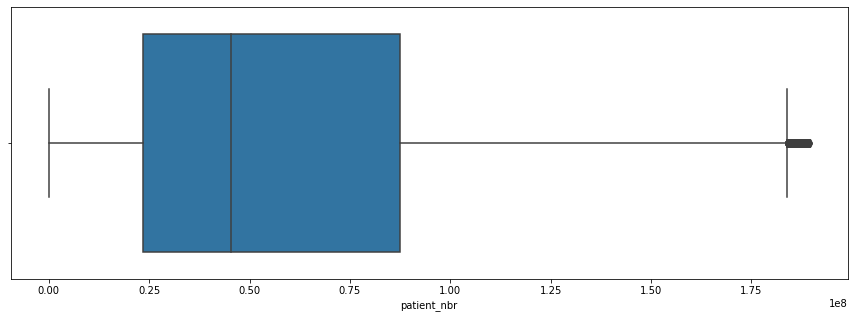

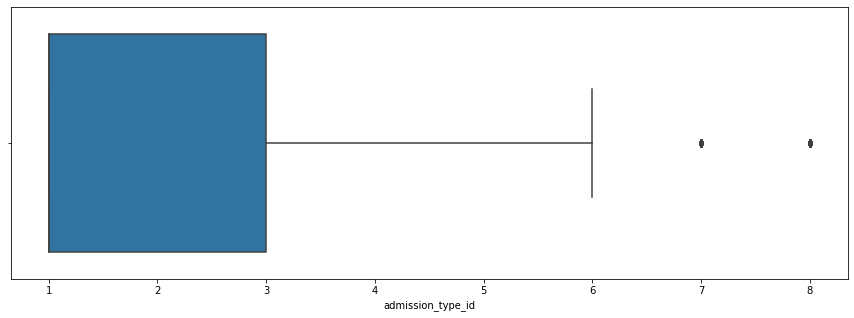

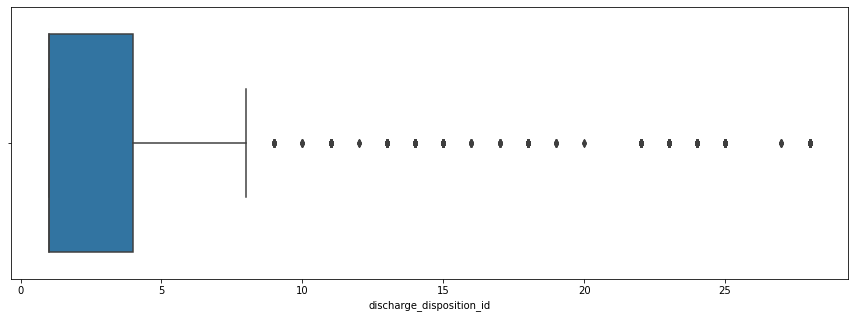

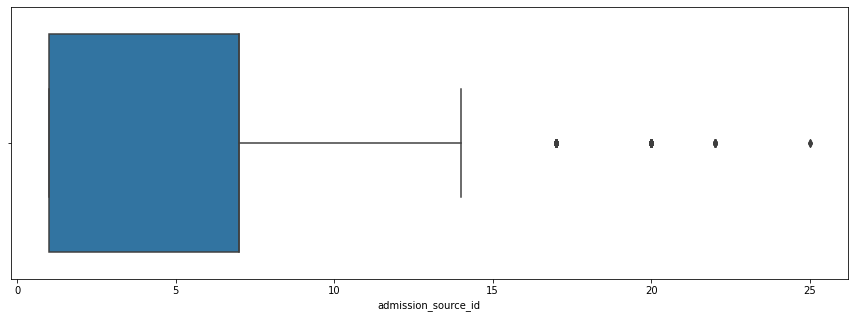

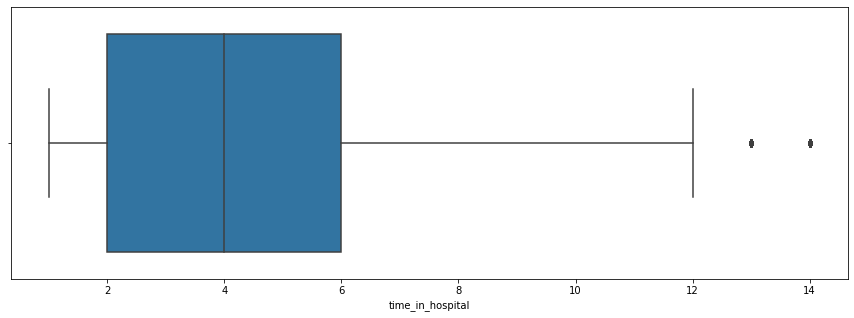

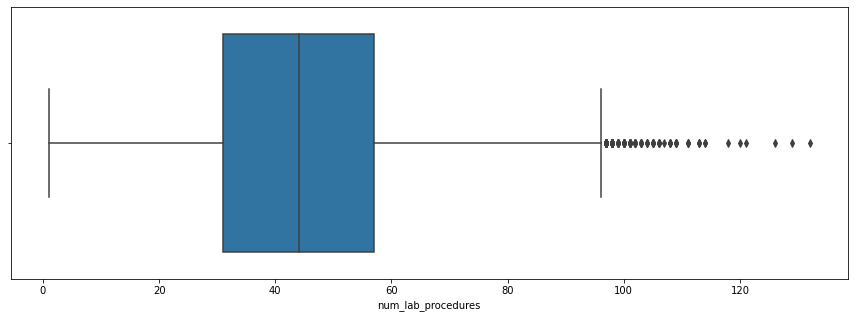

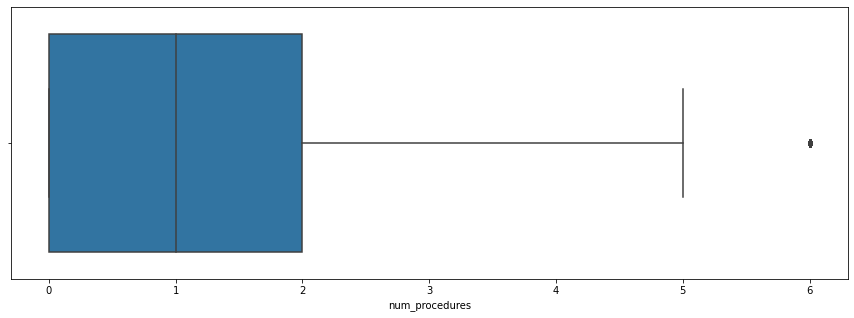

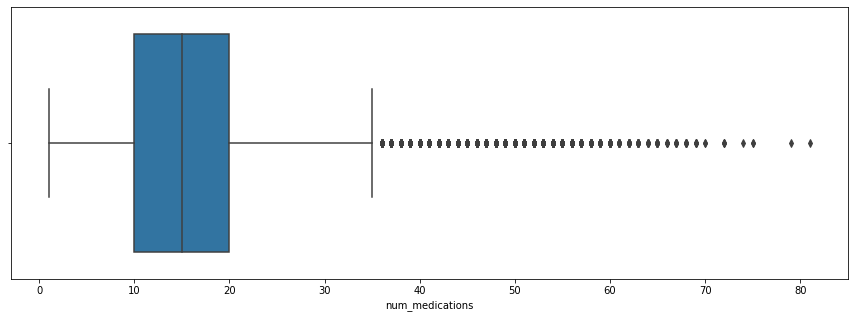

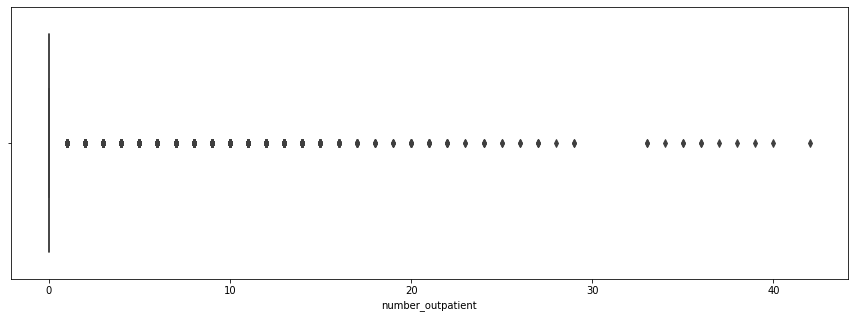

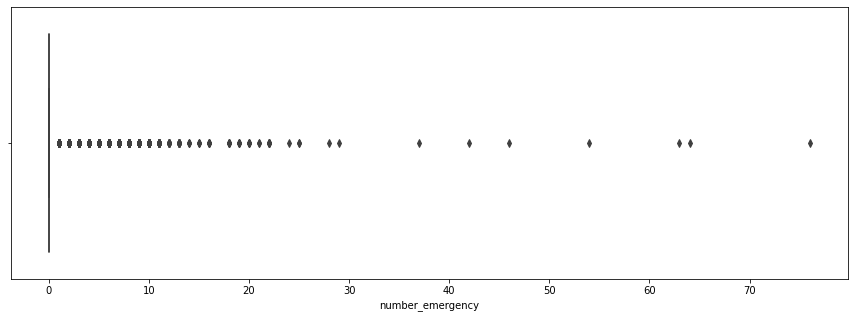

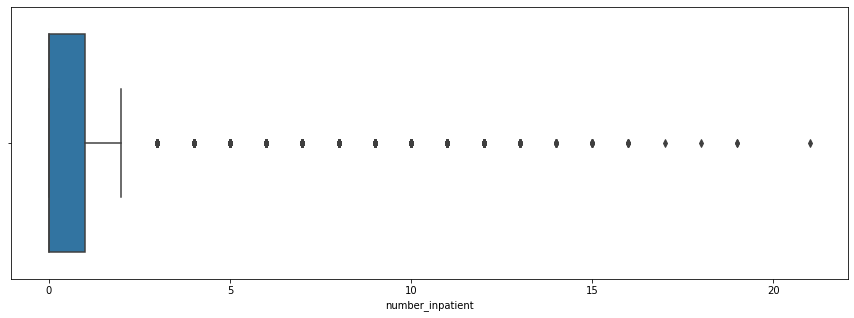

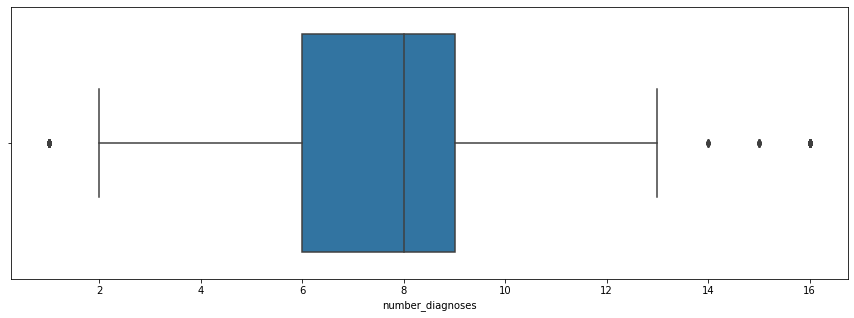

In [44]:
def boxplot(df):
    for col in numeric_columns:
        plt.figure(figsize=(15,5))
        sns.boxplot(data=(diabetic_data.select(col).toPandas()),x=col)
        plt.show()
boxplot(diabetic_data)

# <font color='orange'>Step 3: Data Preparation</font> 

## <font color='grey'> 3.1: Selecting the Data </font> 

### <font color='blue'> 3.1.1: Selecting items(rows) </font> 

In [45]:
diabetic_data.filter((diabetic_data.readmitted=='<30')).count()

11357

In [46]:
diabetic_data.select('gender').toPandas().value_counts()

gender         
Female             54708
Male               47055
Unknown/Invalid        3
dtype: int64

In [47]:
diabetic_data.filter((diabetic_data.gender=="Unknown/Invalid") & (diabetic_data.readmitted=='<30')).count()

0

In [48]:
diabetic_data=diabetic_data.filter(diabetic_data.gender!='Unknown/Invalid')
diabetic_data.select('gender').toPandas().value_counts()

gender
Female    54708
Male      47055
dtype: int64

In [49]:
diabetic_data.select('race').toPandas().value_counts()

race           
Caucasian          76099
AfricanAmerican    19210
?                   2271
Hispanic            2037
Other               1505
Asian                641
dtype: int64

In [50]:
#  Filter Based on List Values
# li=['Caucasian','AfricanAmerican','Hispanic','Other','Asian']
# diabetic_data.filter((diabetic_data.race.isin(li)==False)).count()

In [51]:
# df.filter(df.state.isin(li)==False).show()

In [52]:
# df_stroke[df_stroke['bmi'].isna() & df_stroke['stroke']==1]['stroke'].count()

In [53]:
# total 188 values of "?" in race column are contributing towards the target variable
diabetic_data.filter((diabetic_data.race=="?") & (diabetic_data.readmitted=='<30')).count()


188

In [54]:
diabetic_data=diabetic_data.filter(diabetic_data.race!='?')
diabetic_data.select('race').toPandas().value_counts()

race           
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1505
Asian                641
dtype: int64

In [55]:
# spark.sql("update diabetic_data set readmitted=0 where readmitted='NO' ").show()
# spark.sql("select readmitted from diabetic_data").show()

In [56]:
# spark.sql("update diabetic_data set readmitted=0 where readmitted='>30' ").show()

In [57]:
# Update the readmitted column 
diabetic_data=diabetic_data.withColumn("readmitted", when(col("readmitted") == "NO",0)
      .when(col("readmitted") == "<30",1).when(col("readmitted") == ">30",0))

In [58]:
diabetic_data.select('readmitted').groupBy('readmitted').count().show()

+----------+-----+
|readmitted|count|
+----------+-----+
|         1|11169|
|         0|88323|
+----------+-----+



### <font color='blue'> 3.1.2: Selecting Attributes(Columns) </font> 

In [59]:
diabetic_data.show()

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [60]:
# encounter_id & patient_nbr are just for the records purpose only. So I am deleting these attributes
# diag_1, diag_2, diag_3 have almost similar values. Hence these are correlated,we will use only the diag_1 feature.
diabetic_data=diabetic_data.drop("encounter_id","patient_nbr","diag_2","diag_3")
diabetic_data.show()

+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|

In [61]:
diabetic_data.show()

+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|

In [62]:
# Check number of rows and columns in the data after removing some attributes and records
row=diabetic_data.count()
cols=len(diabetic_data.columns)
print('Total number of columns are - ', cols)
print('\nTotal number of records are - ', row)

Total number of columns are -  46

Total number of records are -  99492


In [63]:
# update the numeric columns now
numeric_columns = [column[0] for column in diabetic_data.dtypes if column[1]=='int']

## <font color='grey'> 3.2: Clean the Data</font> 

### <font color='blue'> 3.2.1: Clean Missing Values </font> 

In [64]:

"""
As We can see in step 2.3, there is no missing values in the data, but I have found the missing values are 
imputed with "?" sign. So, First of all we will replace the "?" sign with none value. and then we will check
the missing values
"""
print(" IMPORTANT 👆👆")


 IMPORTANT 👆👆


In [65]:
# Replace "?" with 'nan' values
diabetic_data = diabetic_data.replace({'?':''}, subset=['race','weight','payer_code','medical_specialty','diag_1'])

In [66]:
# Let's Check is there any values left with "?"
diabetic_data.select([count(when(col(c).contains('?') | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns]).show()

+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|gl

In [67]:

# diabetic_data.select([count(when((col(c)=='') | \
#                             isnan(c), c 
#                            )).alias(c)
#                     for c in diabetic_data.columns]).show()

In [68]:
# Now check the missing values in the dataset 
diabetic_data.select([count(when(col(c).contains('NaN') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns]).show()


+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|gl

In [69]:
# print(round((diabetic_data.filter(diabetic_data.weight=='').count()*100)/(diabetic_data.select('weight').count()),2))

In [70]:
# from pyspark.sql.functions import col
# for cols in diabetic_data.columns:
#     print(round((diabetic_data.filter(" cols =='' ").count()*100)\
#                 /(diabetic_data.select(cols).count()),2))
    

In [71]:
# column weight, payer code, & Medical speciality has Approximately more than 40% missing records
# I will drop these columns from the dataset
diabetic_data=diabetic_data.drop('weight','payer_code','medical_specialty')
# diabetic_data.show()

In [72]:
# remove the missing values in the data
diabetic_data=diabetic_data.filter(diabetic_data.diag_1!='')
# diabetic_data=diabetic_data.filter(diabetic_data.diag_2!='')
# diabetic_data=diabetic_data.filter(diabetic_data.diag_3!='')

In [73]:
# Now check again the missing values in the dataset 
diabetic_data.select([count(when(col(c).contains('NaN') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in diabetic_data.columns]).show()

# Now there is no missing data in the dataset

+----+------+---+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|race|gender|age|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|acetohexamide|glipizide|glyburide|tolbutamide|pioglitazone|rosiglitazone|acarbose|miglitol|troglit

### <font color='blue'> 3.2.2: Clean Outliers </font> 

In [74]:
# After cleaning the missing value, let's find out the total number of outliers
# I have made a function to count the outliers. let's run this
outlier_count()

admission_type_id 5561
discharge_disposition_id 9723
admission_source_id 6871
time_in_hospital 3634
num_lab_procedures 170
num_procedures 7809
num_medications 2865
number_outpatient 99473
number_emergency 99473
number_inpatient 6988
number_diagnoses 269
readmitted 99473


In [75]:
# # Finding Outlier using IQR
# def finding_outlier(df,col):
# #     for col in numeric_columns:
#     df.select(col).toPandas().astype(int)
#     q1=df.approxQuantile(col,[0.25],relativeError=0)
#     q3=df.approxQuantile(col,[0.75],relativeError=0)
#     IQR=q3[0]-q1[0]
#     upper=q3[0]+1.5*IQR
#     lower=q1[0]-1.5*IQR
#     df_1=df.filter((df[col]<=lower) | (df[col]>=upper) )
# #         df_1=df[(df.select(col)<=lower)]
# #         df_2=df[(df.select(col)>=upper)]
# #     df=unionAll([df_1,df_2])

#     return df_1.select(col)

In [76]:
diabetic_data.toPandas().describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,99473.000000,99473.000000,99473.000000,99473.000000,99473.00000,99473.000000,99473.000000,99473.000000,99473.000000,99473.000000,99473.000000,99473.000000
mean,2.027264,3.740502,5.771234,4.398510,43.07407,1.340685,16.026841,0.373398,0.201331,0.643049,7.439315,0.112231
std,1.450888,5.309141,4.072867,2.987168,19.69536,1.703779,8.120171,1.276906,0.940040,1.271394,1.926096,0.315653
min,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,31.00000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.000000,1.000000,7.000000,4.000000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,3.000000,4.000000,7.000000,6.000000,57.00000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,8.000000,28.000000,25.000000,14.000000,132.00000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000


In [77]:
def outliers_removed(df,colm):
#     df.select(col).toPandas().astype(int)
    q1=df.approxQuantile(colm,[0.25],relativeError=0)
    q3=df.approxQuantile(colm,[0.75],relativeError=0)
    IQR=q3[0]-q1[0]
    upper=q3[0]+1.5*IQR
    lower=q1[0]-1.5*IQR
#     df=df[(df[colm]>lower) & (df[colm]<upper)]
#     df.filter((df[colm]>lower) & (df[colm]<upper) )
    return df.filter((df[colm]>lower) & (df[colm]<upper) )

In [78]:
#diabetic_data=
diabetic_data=outliers_removed(diabetic_data,'admission_type_id')

In [79]:
diabetic_data=outliers_removed(diabetic_data,'discharge_disposition_id')

In [80]:
diabetic_data=outliers_removed(diabetic_data,'admission_source_id')

In [81]:
diabetic_data=outliers_removed(diabetic_data,'time_in_hospital')

In [82]:
diabetic_data=outliers_removed(diabetic_data,'num_lab_procedures')

In [83]:
diabetic_data=outliers_removed(diabetic_data,'num_procedures')

In [84]:
diabetic_data=outliers_removed(diabetic_data,'num_medications')

In [85]:
diabetic_data=outliers_removed(diabetic_data,'number_diagnoses')

In [86]:
diabetic_data.toPandas().describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000,58496.000000
mean,1.639770,1.439021,5.074244,3.546208,42.041046,0.893856,13.938748,0.357443,0.213382,0.615632,7.341493,0.106195
std,0.915726,0.894623,2.725096,2.073416,18.973900,1.167910,5.889842,1.270677,1.002319,1.252428,1.954786,0.308090
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.000000,1.000000,7.000000,3.000000,43.000000,0.000000,13.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,2.000000,1.000000,7.000000,5.000000,55.000000,2.000000,18.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,5.000000,5.000000,14.000000,9.000000,91.000000,4.000000,29.000000,37.000000,76.000000,21.000000,13.000000,1.000000


In [87]:
#diabetic_data=
diabetic_data=outliers_removed(diabetic_data,'admission_type_id')

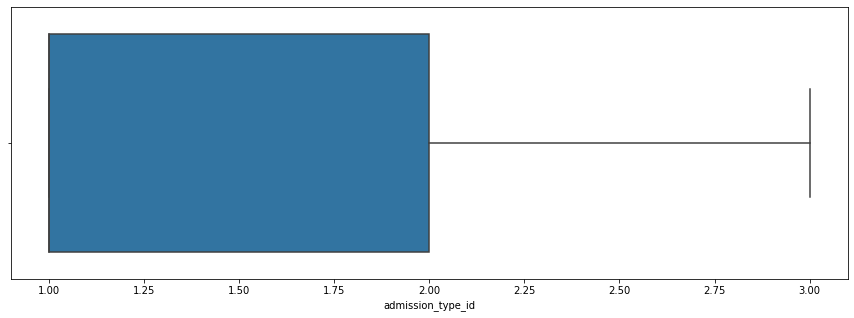

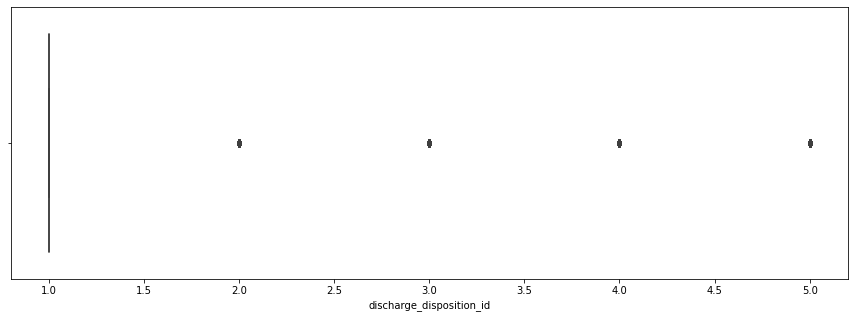

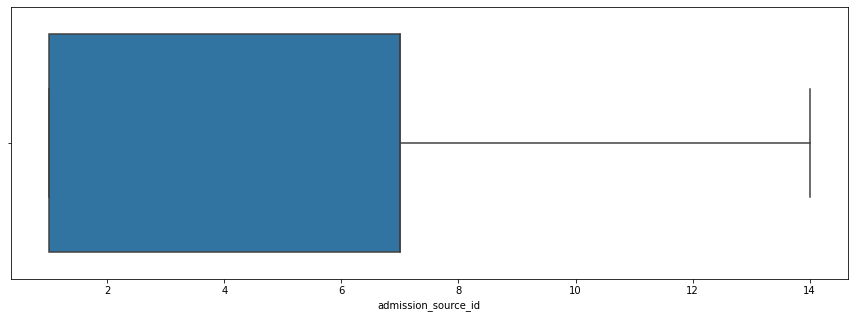

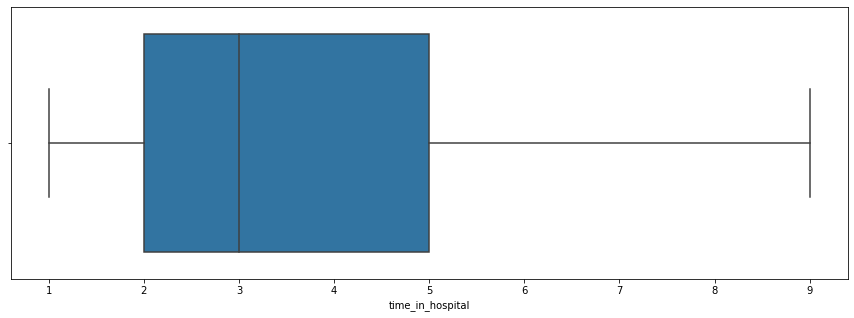

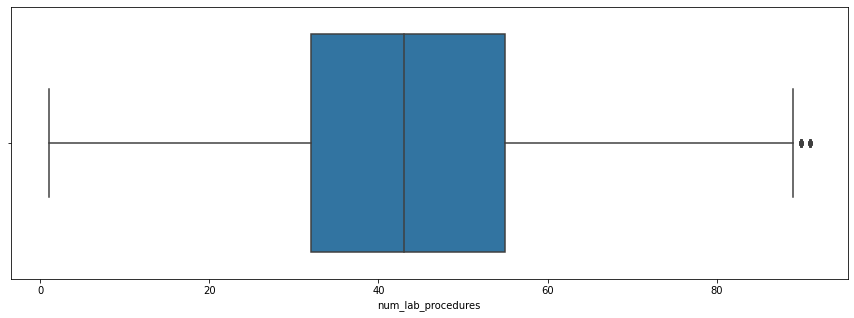

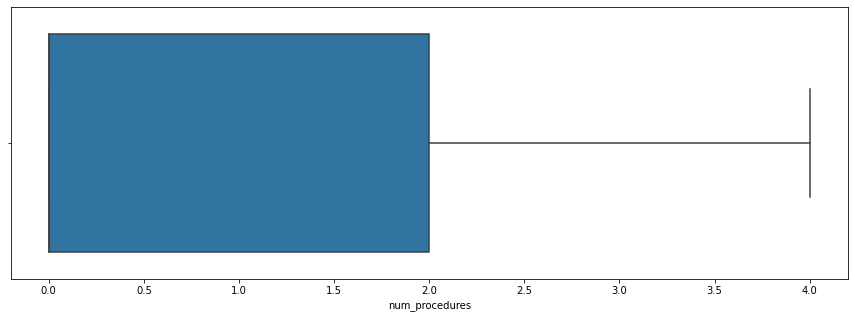

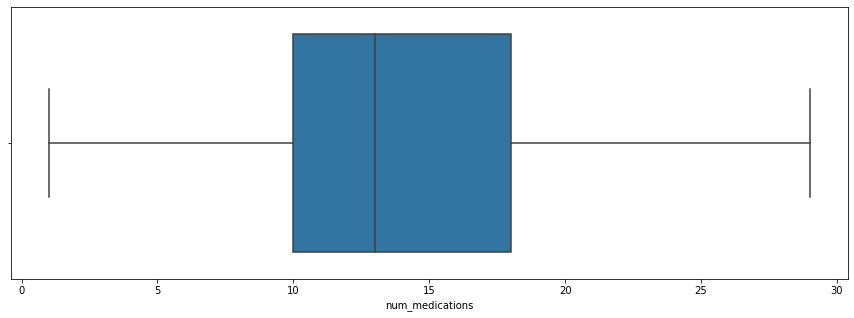

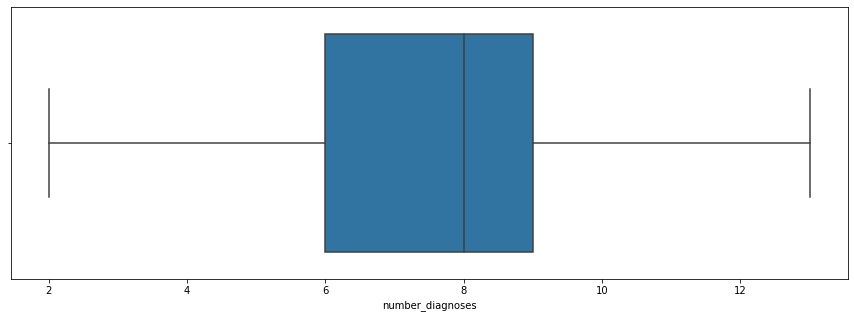

In [88]:
continuous=['admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses']

for cols in continuous:
    plt.figure(figsize=(15,5))
    sns.boxplot(data=(diabetic_data.select(cols).toPandas()),x=cols)
    plt.show()

In [89]:
diabetic_data.toPandas().describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000,57264.000000
mean,1.567564,1.432086,5.151614,3.552249,42.120809,0.892463,13.907568,0.336599,0.214393,0.620250,7.336127,0.106594
std,0.780356,0.891410,2.691398,2.076425,18.940273,1.167598,5.888452,1.213605,1.007810,1.259606,1.956436,0.308599
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.000000,1.000000,7.000000,3.000000,43.000000,0.000000,13.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,2.000000,1.000000,7.000000,5.000000,55.000000,2.000000,18.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,3.000000,5.000000,14.000000,9.000000,91.000000,4.000000,29.000000,37.000000,76.000000,21.000000,13.000000,1.000000


In [90]:
# Check number of rows and columns in the data after Cleaning the data
row=diabetic_data.count()
cols=len(diabetic_data.columns)
print('Total number of columns are - ', cols)
print('\nTotal number of records are - ', row)

Total number of columns are -  43

Total number of records are -  57264


<Figure size 1080x360 with 0 Axes>

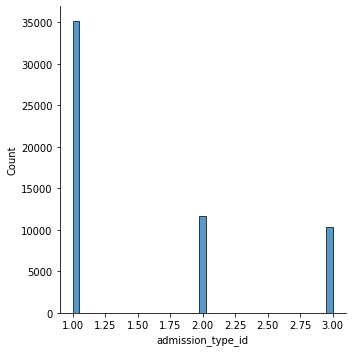

<Figure size 1080x360 with 0 Axes>

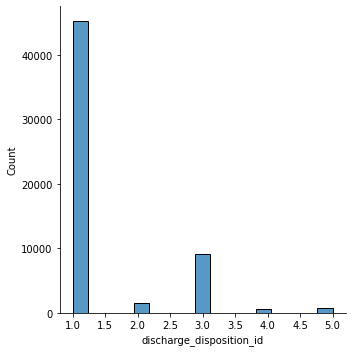

<Figure size 1080x360 with 0 Axes>

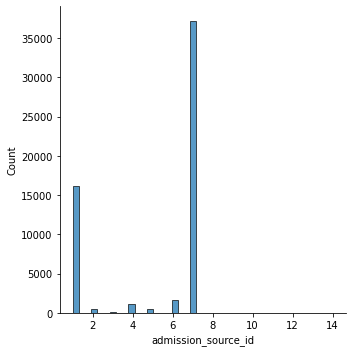

<Figure size 1080x360 with 0 Axes>

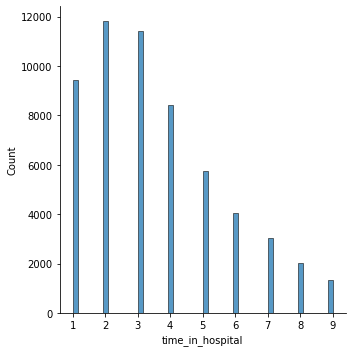

<Figure size 1080x360 with 0 Axes>

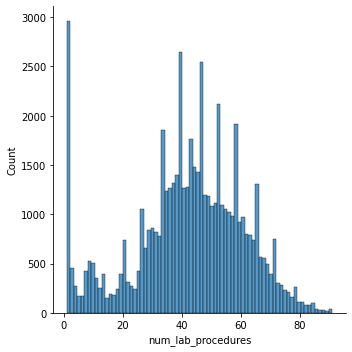

<Figure size 1080x360 with 0 Axes>

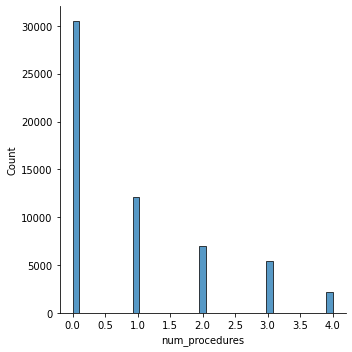

<Figure size 1080x360 with 0 Axes>

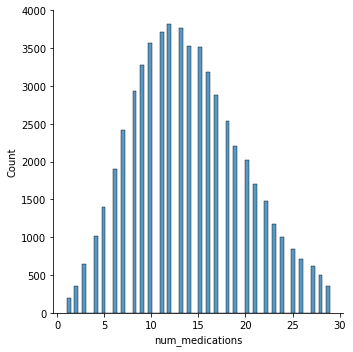

<Figure size 1080x360 with 0 Axes>

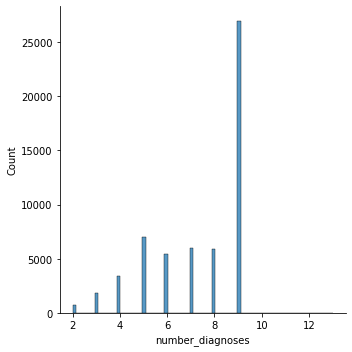

In [91]:
for cols in continuous:
    plt.figure(figsize=(15,5))
    sns.displot(data=(diabetic_data.select(cols).toPandas()),x=cols)
    plt.show()

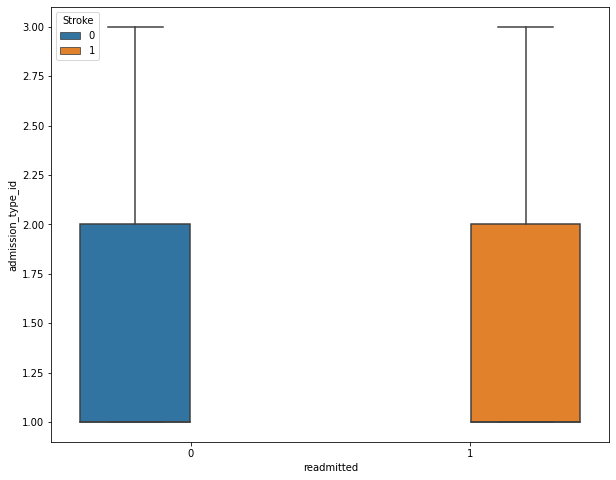

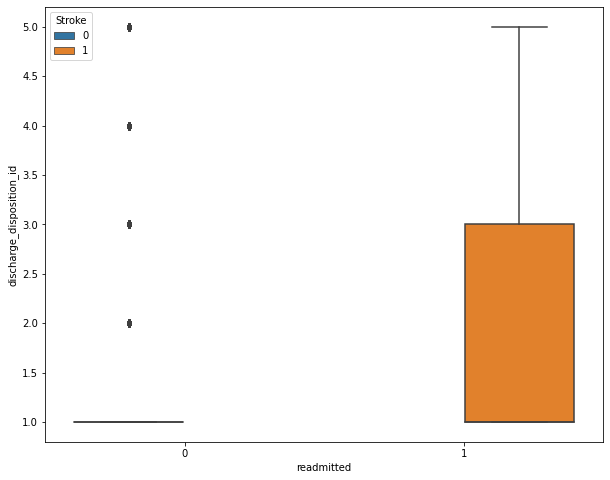

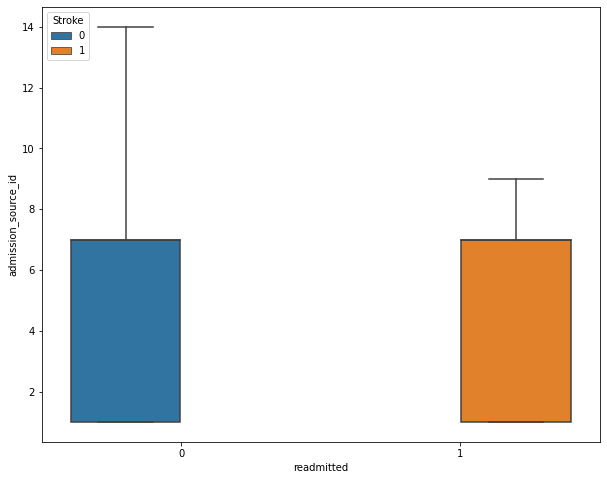

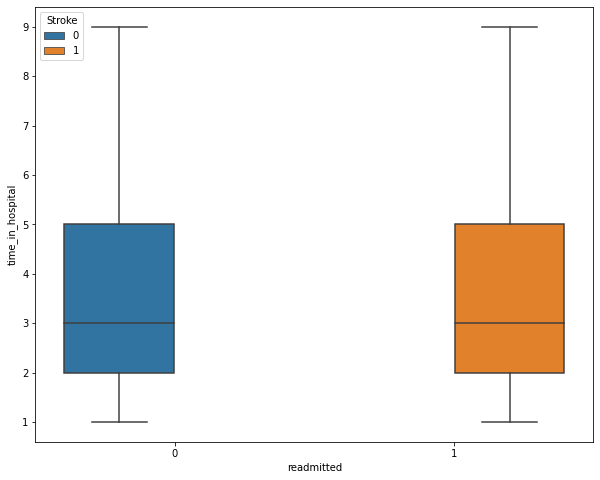

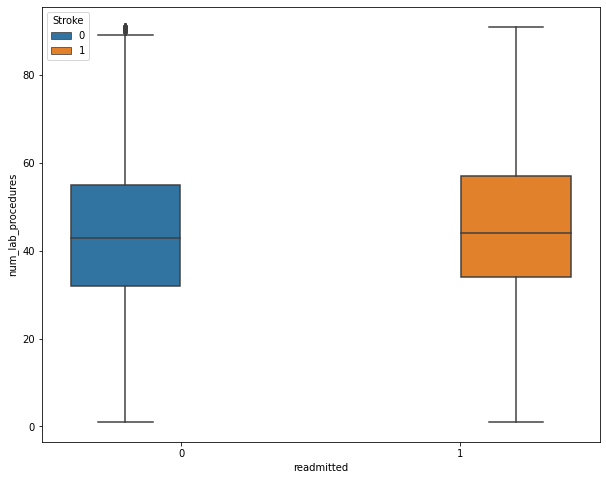

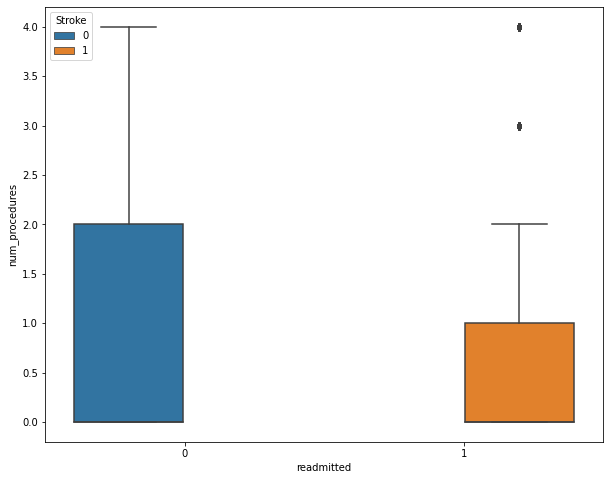

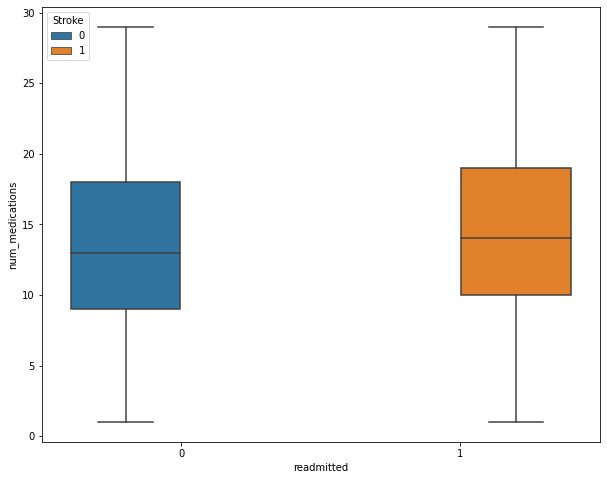

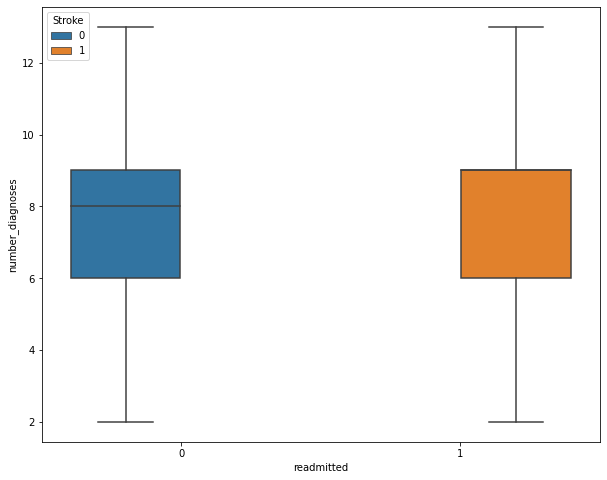

In [92]:
# This code will plot a boxplot of different variable with respect of target attribute stroke
for cols in continuous:
    plt.figure(figsize=(10,8))

    sns.boxplot(x='readmitted',y=cols,hue='readmitted', data=(diabetic_data.toPandas()))
    plt.legend(loc='upper left',title='Stroke')

    plt.show()

## <font color='grey'> 3.3: Constructing New Data</font> 

<AxesSubplot:xlabel='age', ylabel='count'>

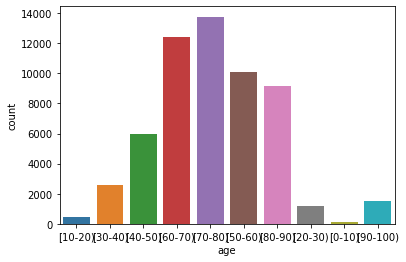

In [93]:
sns.countplot(data=(diabetic_data.select('age').toPandas()),x='age')

In [94]:
diabetic_data.select('age').groupBy('age').count().sort('age').show()

+--------+-----+
|     age|count|
+--------+-----+
|  [0-10)|  101|
| [10-20)|  484|
| [20-30)| 1193|
| [30-40)| 2592|
| [40-50)| 5960|
| [50-60)|10058|
| [60-70)|12386|
| [70-80)|13765|
| [80-90)| 9179|
|[90-100)| 1546|
+--------+-----+



In [95]:
#create a new column based on the the previous column
diabetic_data=diabetic_data.withColumn("age_category",col("age"))


In [96]:
# replacing the values in the reconstructing column
diabetic_data=diabetic_data.replace({'[0-10)':'Minor','[10-20)':'Minor','[20-30)':'Young_adult',
               '[30-40)':'Young_adult', '[40-50)':'Middle_aged','[50-60)':'Middle_aged',
               '[60-70)':'Older_adult','[70-80)':'Older_adult',
               '[80-90)':'Elderly','[90-100)':'Elderly'},subset=['age_category'])
# Check the total values in each category
diabetic_data.select('age_category').groupBy('age_category').count().sort('age_category').show()

+------------+-----+
|age_category|count|
+------------+-----+
|     Elderly|10725|
| Middle_aged|16018|
|       Minor|  585|
| Older_adult|26151|
| Young_adult| 3785|
+------------+-----+



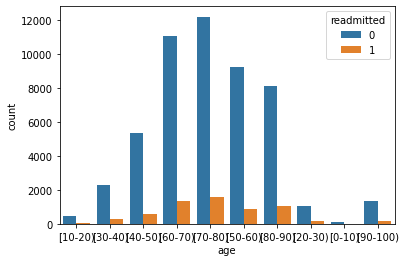

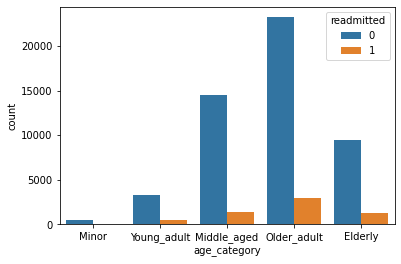

In [97]:
# THe comparision of the previous and the current 
sns.countplot(data=(diabetic_data.select('age','readmitted').toPandas()),x='age',hue='readmitted')
plt.show()
sns.countplot(data=(diabetic_data.select('age_category','readmitted').toPandas()),x='age_category',hue='readmitted')
plt.show()

In [98]:
#Drop the previous column after reconstructing the new column
diabetic_data=diabetic_data.drop('age')
diabetic_data.columns

['race',
 'gender',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'readmitted',
 'age_category']

## <font color='grey'> 3.4: Integrating Data</font> 

In [99]:
#.cache() is advised for consistency, because without it limited_df and rest_df can have overlapping rows
limited_df = diabetic_data.limit(25000).cache()
rest_df = diabetic_data.subtract(limited_df)

In [100]:
print(limited_df.count())
# limited_df.show(1)

25000


In [101]:
print(rest_df.count())
# rest_df.show(1)

32263


In [102]:
import functools
 
# explicit function
def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)
 
 
diabetic_data = unionAll([limited_df,rest_df])
diabetic_data.count()

57263

## <font color='grey'> 3.5: Data Formatting</font> 

In [103]:
diabetic_data.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nu

In [104]:
# Cast Course_Fees from integer type to float type
from pyspark.sql.types import BooleanType
diabetic_data = diabetic_data.withColumn("readmitted", 
                                  diabetic_data["readmitted"]
                                  .cast(BooleanType()))
diabetic_data.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nu

# <font color='orange'>Step 4: Data Transformation</font> 

## <font color='grey'> 4.1: Data Reduction</font> 

In [105]:
from pyspark.ml.feature import StringIndexer


In [106]:
a=StringIndexer(inputCol="race", outputCol="Race")
b=StringIndexer(inputCol="gender", outputCol="Gender")
c=StringIndexer(inputCol="max_glu_serum", outputCol="Max_glu_serum")
d=StringIndexer(inputCol="A1Cresult", outputCol="AA1Cresult")
e=StringIndexer(inputCol="metformin", outputCol="Metformin")
f=StringIndexer(inputCol="repaglinide", outputCol="Repaglinide")
g=StringIndexer(inputCol="nateglinide", outputCol="Nateglinide")
h=StringIndexer(inputCol="chlorpropamide", outputCol="Chlorpropamide")
i=StringIndexer(inputCol="glimepiride", outputCol="Glimepiride")
j=StringIndexer(inputCol="acetohexamide", outputCol="Acetohexamide")
k=StringIndexer(inputCol="glipizide", outputCol="Glipizide")
l=StringIndexer(inputCol="glyburide", outputCol="Glyburide")
m=StringIndexer(inputCol="tolbutamide", outputCol="Tolbutamide")
n=StringIndexer(inputCol="pioglitazone", outputCol="Pioglitazone")
o=StringIndexer(inputCol="rosiglitazone", outputCol="Rosiglitazone")
p=StringIndexer(inputCol="acarbose", outputCol="Acarbose")
q=StringIndexer(inputCol="miglitol", outputCol="Miglitol")
r=StringIndexer(inputCol="troglitazone", outputCol="Troglitazone")
s=StringIndexer(inputCol="tolazamide", outputCol="Tolazamide")
t=StringIndexer(inputCol="examide", outputCol="Examide")
u=StringIndexer(inputCol="citoglipton", outputCol="Citoglipton")
v=StringIndexer(inputCol="insulin", outputCol="Insulin")
w=StringIndexer(inputCol="glyburide-metformin", outputCol="Glyburide_metformin")
x=StringIndexer(inputCol="glipizide-metformin", outputCol="Glipizide_metformin")
y=StringIndexer(inputCol="glimepiride-pioglitazone", outputCol="Glimepiride_pioglitazone")
z=StringIndexer(inputCol="metformin-rosiglitazone", outputCol="Metformin_rosiglitazone")
a1=StringIndexer(inputCol="metformin-pioglitazone", outputCol="Metformin_pioglitazone")
a2=StringIndexer(inputCol="change", outputCol="Change")
a3=StringIndexer(inputCol="diabetesMed", outputCol="DiabetesMed")
a4=StringIndexer(inputCol="age_category", outputCol="Age_category")
a5=StringIndexer(inputCol="diag_1", outputCol="Diag_1")


In [107]:
abc=diabetic_data
aa=a.fit(abc).transform(abc)
ab=b.fit(aa).transform(aa)
ac=c.fit(ab).transform(ab)
ad=d.fit(ac).transform(ac)
ae=e.fit(ad).transform(ad)
af=f.fit(ae).transform(ae)
ag=g.fit(af).transform(af)
ah=h.fit(ag).transform(ag)
ai=i.fit(ah).transform(ah)
aj=j.fit(ai).transform(ai)
ak=k.fit(aj).transform(aj)
al=l.fit(ak).transform(ak)
am=m.fit(al).transform(al)
an=n.fit(am).transform(am)
ao=o.fit(an).transform(an)
ap=p.fit(ao).transform(ao)
aq=q.fit(ap).transform(ap)
ar=r.fit(aq).transform(aq)
ast=s.fit(ar).transform(ar)
at=t.fit(ast).transform(ast)
au=u.fit(at).transform(at)
av=v.fit(au).transform(au)
aw=w.fit(av).transform(av)
ax=x.fit(aw).transform(aw)
ay=y.fit(ax).transform(ax)
az=a1.fit(ay).transform(ay)
ba=a2.fit(az).transform(az)
bb=a3.fit(ba).transform(ba)
bc=a4.fit(bb).transform(bb)
bd=a5.fit(bc).transform(bc)
# be=a.fit(bd).transform(bd)


In [108]:
len(bd.columns)

48

In [109]:
bcd=bd.select('Race', 'Gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'Diag_1', 'number_diagnoses', 'Max_glu_serum', 'A1Cresult', 'Metformin', 'Repaglinide', 'Nateglinide', 'Chlorpropamide', 'Glimepiride', 'Acetohexamide', 'Glipizide', 'Glyburide', 'Tolbutamide', 'Pioglitazone', 'Rosiglitazone', 'Acarbose', 'Miglitol', 'Troglitazone', 'Tolazamide', 'Examide', 'Citoglipton', 'Insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'Change', 'DiabetesMed',  'Age_category', 'AA1Cresult', 'Glyburide_metformin', 'Glipizide_metformin', 'Glimepiride_pioglitazone', 'Metformin_pioglitazone','readmitted')
len(bcd.columns)

48

In [110]:
bcd=bcd.drop( 'A1Cresult',  'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone')
bcd.columns
len(bcd.columns)

42

In [111]:
diabetic_data=bcd

In [112]:
diabetic_data.select('citoglipton').toPandas().value_counts()

citoglipton
0.0            57263
dtype: int64

In [113]:
diabetic_data.select('examide').toPandas().value_counts()

examide
0.0        57263
dtype: int64

In [114]:
# Column examide and 'citrogilptone' has only 1 values, so to avoid biaseness, we are removing these columns
diabetic_data=diabetic_data.drop('examide','citoglipton')
len(diabetic_data.columns)

40

## <font color='grey'> 4.2: Data Projection</font> 

In [115]:
n_col=diabetic_data.columns
n_col.remove("readmitted")

# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=n_col,outputCol="features")

# Now let us use the transform method to transform our dataset
diabetic_data_1=assembler.transform(diabetic_data)
diabetic_data_1.select("features").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|features                                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|(39,[2,3,4,5,6,8,12,13,30,31,33],[1.0,1.0,7.0,3.0,59.0,18.0,7.0,9.0,3.0,1.0,4.0])                          |
|(39,[1,2,3,4,5,6,7,8,12,13,30,31,33],[1.0,1.0,1.0,7.0,2.0,44.0,1.0,16.0,37.0,7.0,3.0,1.0,3.0])             |
|(39,[1,2,3,4,5,6,8,12,13,21,30,31,33],[1.0,1.0,1.0,7.0,1.0,51.0,8.0,81.0,5.0,1.0,1.0,1.0,1.0])             |
|(39,[1,2,3,4,5,6,7,8,12,13,15,19,30,31],[1.0,3.0,1.0,2.0,4.0,70.0,1.0,21.0,2.0,7.0,1.0,1.0,1.0,1.0])       |
|(39,[1,2,3,4,5,6,8,13,22],[1.0,1.0,1.0,7.0,5.0,73.0,12.0,8.0,1.0])                                         |
|(39,[0,2,3,4,5,6,7,8,12,13,30,33],[1.0,1.0,1.0,7.0,9.0,47.0,2.0,17.0,42.0,9.0,1.0,1.0])                    |
|(39,[0,1,

In [116]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
diabetic_data_1=standardscaler.fit(diabetic_data_1).transform(diabetic_data_1)
diabetic_data_1.select("features","Scaled_features").show(5)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|(39,[2,3,4,5,6,8,...|(39,[2,3,4,5,6,8,...|
|(39,[1,2,3,4,5,6,...|(39,[1,2,3,4,5,6,...|
|(39,[1,2,3,4,5,6,...|(39,[1,2,3,4,5,6,...|
|(39,[1,2,3,4,5,6,...|(39,[1,2,3,4,5,6,...|
|(39,[1,2,3,4,5,6,...|(39,[1,2,3,4,5,6,...|
+--------------------+--------------------+
only showing top 5 rows



In [117]:
diabetic_data_1 = diabetic_data_1.withColumn("readmitted", 
                                  diabetic_data_1["readmitted"]
                                  .cast('int'))

In [118]:
dataset_size=float(diabetic_data_1.select("readmitted").count())
numPositives=diabetic_data_1.select("readmitted").where('readmitted == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 6104
Percentage of ones are 10.659588215776331


In [119]:

# Implement oversampling method
import pyspark.sql.functions as F

# calculate ratio
major_df = diabetic_data_1.filter(diabetic_data_1.readmitted == 0)
minor_df = diabetic_data_1.filter(diabetic_data_1.readmitted == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))
a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

ratio: 8


In [120]:
dataset_size=float(combined_df.select("readmitted").count())
numPositives=combined_df.select("readmitted").where('readmitted == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 48832
Percentage of ones are 48.8363952755748


In [121]:
combined_df.select('readmitted').toPandas().value_counts()

readmitted
0             51159
1             48832
dtype: int64

# <font color='orange'>Step 5: Data Mining Method</font> 

5.1 - Match and discuss DM methods within the context of the DM objectives.

5.2 - Select the appropriate DM method(s) in a logical manner. The selected DM method must be in line with the data mining goal/success criteria.

## <font color='grey'> 5.1: Match and Discuss DM Methods</font> 

## <font color='grey'> 5.2: Select Appropriate DM Methods</font> 

#  <font color='orange'>Step 6: Data Mining Algorithm Selection</font> 

6.1 Conduct exploratory analysis of DM algorithms within the context of the DM objectives. Then, discuss the analysis.
6.2 - Select algorithm(s) in a logical manner based on the exploratory analysis and discussion.
6.3 - Model(s) must be selected/built, and the appropriate algorithm/model parameter(s) must be selected.

## <font color='grey'> 6.1: Exploratory analysis of DM algorithms</font> 

In [122]:
train, test = (combined_df.select('Scaled_features','readmitted')).randomSplit([0.70, 0.30], seed = 12345)

### <font color='skyblue'> 6.1.1:Logistic Regression Algorithm</font> 

In [123]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="readmitted", featuresCol="Scaled_features",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)

# from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='readmitted')
predict_test.select("readmitted","rawPrediction","prediction","probability").show(20)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+----------+--------------------+----------+--------------------+
|readmitted|       rawPrediction|prediction|         probability|
+----------+--------------------+----------+--------------------+
|         0|[-3.2770533825198...|       1.0|[0.03636683754056...|
|         0|[0.58709706838266...|       0.0|[0.64269880153310...|
|         0|[0.15193416918926...|       0.0|[0.53791064292540...|
|         0|[-0.4582130835952...|       1.0|[0.38740981561197...|
|         0|[-0.6222140811414...|       1.0|[0.34927806086887...|
|         0|[0.05058959027055...|       0.0|[0.51264470087708...|
|         0|[-0.0596720225027...|       1.0|[0.48508641940639...|
|         0|[0.17145708805919...|       0.0|[0.54275957114434...|
|         0|[0.75280717080059...|       0.0|[0.67979005973268...|
|         0|[0.78137078349719...|       0.0|[0.68597547394296...|
|         0|[0.93774525003615...|       0.0|[0.71864398351388...|
|         0|[-0.4122686251756...|       1.0|[0.39836827234658...|
|         

The area under ROC for train set is 0.6627934102726329


The area under ROC for test set is 0.6561057267511949


In [124]:
#confusion Matrix
cm_lr_result = predict_test.crosstab("prediction", "readmitted")
cm_lr_result = cm_lr_result.toPandas()
cm_lr_result

,prediction_readmitted,0,1
0,1.0,4409,7342
1,0.0,11094,7287


In [125]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_lr_result["1"][0]
FP = cm_lr_result["0"][0]
TN = cm_lr_result["0"][1]
FN = cm_lr_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity/Recall = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.61
Sensitivity/Recall = 0.50
Specificity = 0.72
Precision = 0.62


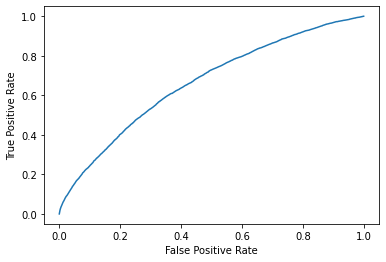

0.6627851251962611

In [126]:
import matplotlib.pyplot as plt
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
model.summary.areaUnderROC

### <font color='skyblue'> 6.1.2:Random Forest Algorithm</font> 

In [127]:
# # Pandas DF operation
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from numpy import array
# #pyspark
# import pyspark
# from pyspark.sql import SparkSession
# import warnings
# warnings.simplefilter(action='ignore')
# from pyspark.sql.functions import col
# from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
# import pyspark.sql.functions as func
# from pyspark.sql.functions import isnull
# from pyspark.sql.functions import isnan, when, count, col, round
# from pyspark.sql.functions import mean
# from pyspark.sql.types import Row
# import matplotlib.pyplot as plt
# from pyspark.sql.functions import udf



# # Modeling + Evaluation
# from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
# from pyspark.sql.functions import when
# from pyspark.sql import functions as F
# from pyspark.sql.functions import avg
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# from pyspark.mllib.evaluation import BinaryClassificationMetrics
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import log_loss
# from pyspark.sql import Window
# from pyspark.sql.functions import rank,sum,col
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.feature import VectorSlicer

In [128]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'Scaled_features', labelCol = 
                            'readmitted')
rf_model = rf.fit(train)
predict_train_rf=rf_model.transform(train)
predict_test_rf=rf_model.transform(test)
predict_test_rf.select("readmitted","prediction").show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = rf_model.transform(test)
auc = BinaryClassificationEvaluator().setLabelCol('readmitted')
print('AUC of the model:' + str(auc.evaluate(predictions)))

+----------+----------+
|readmitted|prediction|
+----------+----------+
|         0|       1.0|
|         0|       0.0|
|         0|       1.0|
|         0|       1.0|
|         0|       1.0|
|         0|       1.0|
|         0|       1.0|
|         0|       1.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 10 rows



AUC of the model:0.6599422782111367


In [129]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='readmitted')
predict_test.select("readmitted","rawPrediction","prediction","probability").show(20)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train_rf)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test_rf)))

+----------+--------------------+----------+--------------------+
|readmitted|       rawPrediction|prediction|         probability|
+----------+--------------------+----------+--------------------+
|         0|[-3.2770533825198...|       1.0|[0.03636683754056...|
|         0|[0.58709706838266...|       0.0|[0.64269880153310...|
|         0|[0.15193416918926...|       0.0|[0.53791064292540...|
|         0|[-0.4582130835952...|       1.0|[0.38740981561197...|
|         0|[-0.6222140811414...|       1.0|[0.34927806086887...|
|         0|[0.05058959027055...|       0.0|[0.51264470087708...|
|         0|[-0.0596720225027...|       1.0|[0.48508641940639...|
|         0|[0.17145708805919...|       0.0|[0.54275957114434...|
|         0|[0.75280717080059...|       0.0|[0.67979005973268...|
|         0|[0.78137078349719...|       0.0|[0.68597547394296...|
|         0|[0.93774525003615...|       0.0|[0.71864398351388...|
|         0|[-0.4122686251756...|       1.0|[0.39836827234658...|
|         

The area under ROC for train set is 0.668321874705361


The area under ROC for test set is 0.6599422782111367


Random Forest Area Under ROC


Area under ROC = 0.66


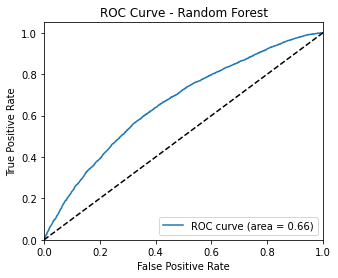

In [130]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
#ROC Grafik
PredAndLabels           = predict_test_rf.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Random Forest Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [131]:
#confusion Matrix
cm_rf_result = predict_test_rf.crosstab("prediction", "readmitted")
cm_rf_result = cm_rf_result.toPandas()
cm_rf_result

,prediction_readmitted,0,1
0,1.0,5606,8803
1,0.0,9897,5826


In [132]:
#calculate Accuracy, Sensitivity, Specificity, Precision for Random Forest Classifier
TP = cm_rf_result["1"][0]
FP = cm_rf_result["0"][0]
TN = cm_rf_result["0"][1]
FN = cm_rf_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity/Recall = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.62
Sensitivity/Recall = 0.60
Specificity = 0.64
Precision = 0.61


### <font color='skyblue'> 6.1.3: Decision Tree Algorithm</font> 

+----------+----------+--------------------+
|readmitted|prediction|         probability|
+----------+----------+--------------------+
|         0|       1.0|[0.38615645537417...|
|         0|       0.0|[0.63703472005004...|
|         0|       1.0|[0.38615645537417...|
|         0|       1.0|[0.38615645537417...|
|         0|       1.0|[0.38615645537417...|
+----------+----------+--------------------+
only showing top 5 rows



Decision Tree Performance Measure
Accuracy = 0.61
AUC = 0.62


Decision Tree Area Under ROC


Area under ROC = 0.62


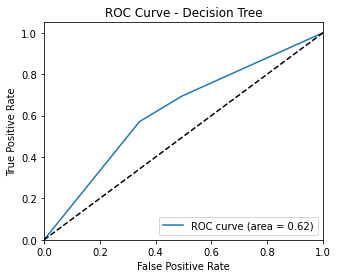

Accuracy = 0.61
Sensitivity = 0.66
Specificity = 0.57
Precision = 0.59
AUC=0.62
GINI ~=0.24


In [133]:
#Decision Tree
#Create decision tree model to data train
dt=DecisionTreeClassifier(featuresCol = 'Scaled_features', labelCol = 'readmitted', maxDepth = 3)
dt_model = dt.fit(train)

##Transform model to data test
dt_result = dt_model.transform(test)

#view id, label, prediction and probability from result of modelling
dt_result.select( 'readmitted', 'prediction', 'probability').show(5)

# Decision Tree Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
dt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="readmitted")
dt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
dt_AUC  = dt_eval.evaluate(dt_result)
dt_ACC  = dt_eval2.evaluate(dt_result, {dt_eval2.metricName:"accuracy"})

print("Decision Tree Performance Measure")
print("Accuracy = %0.2f" % dt_ACC)
print("AUC = %.2f" % dt_AUC)

#ROC Grafik
PredAndLabels           = dt_result.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Decision Tree Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

#confusion matrix
cm_dt_result = dt_result.crosstab("prediction", "readmitted")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result

#calculate accuracy, sensitivity, specificity and precision
TP = cm_dt_result["1"][0]
FP = cm_dt_result["0"][0]
TN = cm_dt_result["0"][1]
FN = cm_dt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coeffiecient from AUC
AUC = dt_AUC
Gini_dt = (2 * AUC - 1)
print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_dt)

### <font color='skyblue'> 6.1.4:Gradient Boosting Algorithm</font> 

22/10/12 08:58:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/12 08:58:22 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


+----------+----------+--------------------+
|readmitted|prediction|         probability|
+----------+----------+--------------------+
|         0|       1.0|[0.10977512854918...|
|         0|       0.0|[0.61407372690512...|
|         0|       1.0|[0.40636106251467...|
|         0|       1.0|[0.37292867025295...|
|         0|       1.0|[0.37996768068532...|
+----------+----------+--------------------+
only showing top 5 rows



Gradient Boosted Tree Performance Measure
Accuracy = 0.63
AUC = 0.68


Gradient Boosting Area Under ROC
Area under ROC = 0.68


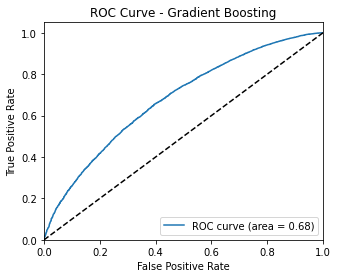

Accuracy = 0.63
Sensitivity = 0.62
Specificity = 0.64
Precision = 0.62
AUC=0.68
GINI ~=0.36


In [134]:
#Gradient Boosting
#create gradient boosting model in data train
gbt = GBTClassifier(featuresCol="Scaled_features", labelCol="readmitted",  maxIter=10)
gbt_model = gbt.fit(train)

#transfrom model to data test
gbt_result = gbt_model.transform(test)

#view id, label, prediction and probability from result of modelling
gbt_result.select( 'readmitted', 'prediction', 'probability').show(5)

#Gradient Boosting Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability",labelCol="readmitted")
gbt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
gbt_AUC  = gbt_eval.evaluate(gbt_result)
gbt_ACC  = gbt_eval2.evaluate(gbt_result, {gbt_eval2.metricName:"accuracy"})

print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_ACC)
print("AUC = %.2f" % gbt_AUC)

#ROC Grafik
PredAndLabels           = gbt_result.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix
cm_gbt_result = gbt_result.crosstab("prediction", "readmitted")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result["1"][0]
FP = cm_gbt_result["0"][0]
TN = cm_gbt_result["0"][1]
FN = cm_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coefficient from AUC
AUC = gbt_AUC
Gini_gbt= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt)


## <font color='grey'> 6.2: Select algorithm(s) in a logical manner</font> 

## <font color='grey'> 6.3: Model Selection</font> 

#  <font color='orange'>Step 7: Data Mining </font> 

## <font color='grey'> 7.1: Create Logical Test</font> 

## <font color='grey'> 7.2: Conducting Data Mining (Model running!)</font> 

## <font color='grey'> 7.3: Searching for Patterns</font> 

# <font color='orange'>Step 8: Interpretation</font> 

## <font color='grey'> 8.1: Study and discuss the mined patterns</font> 

## <font color='grey'> 8.2: Visualize the data, results, models and patterns</font> 

## <font color='grey'> 8.3: Interpret the data, results, models and patterns</font> 

## <font color='grey'> 8.4: Assess and evaluate the data, results, models and patterns</font> 

## <font color='grey'> 8.5: Multiple Iterations</font> 

### <font color='skyblue'> 8.5.1:1st Iteration</font> 

In [135]:
train, test = (combined_df.select('Scaled_features','readmitted')).randomSplit([0.80, 0.20], seed = 12345)

+----------+----------+--------------------+
|readmitted|prediction|         probability|
+----------+----------+--------------------+
|         0|       1.0|[0.12482734677890...|
|         0|       1.0|[0.38556568323051...|
|         0|       1.0|[0.37288061108553...|
|         0|       1.0|[0.49129378855827...|
|         0|       1.0|[0.40313817742143...|
+----------+----------+--------------------+
only showing top 5 rows



Gradient Boosted Tree Performance Measure
Accuracy = 0.63
AUC = 0.68


Gradient Boosting Area Under ROC
Area under ROC = 0.68


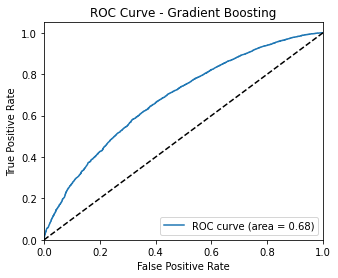

Accuracy = 0.63
Sensitivity = 0.62
Specificity = 0.64
Precision = 0.62
AUC=0.68
GINI ~=0.36


In [136]:
#Gradient Boosting
#create gradient boosting model in data train
gbt = GBTClassifier(featuresCol="Scaled_features", labelCol="readmitted",  maxIter=10)
gbt_model = gbt.fit(train)

#transfrom model to data test
gbt_result = gbt_model.transform(test)

#view id, label, prediction and probability from result of modelling
gbt_result.select( 'readmitted', 'prediction', 'probability').show(5)

#Gradient Boosting Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability",labelCol="readmitted")
gbt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
gbt_AUC  = gbt_eval.evaluate(gbt_result)
gbt_ACC  = gbt_eval2.evaluate(gbt_result, {gbt_eval2.metricName:"accuracy"})

print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_ACC)
print("AUC = %.2f" % gbt_AUC)

#ROC Grafik
PredAndLabels           = gbt_result.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix
cm_gbt_result = gbt_result.crosstab("prediction", "readmitted")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result["1"][0]
FP = cm_gbt_result["0"][0]
TN = cm_gbt_result["0"][1]
FN = cm_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coefficient from AUC
AUC = gbt_AUC
Gini_gbt= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt)


### <font color='skyblue'> 8.5.2: Second Iteration</font> 

In [137]:
train, test = (combined_df.select('Scaled_features','readmitted')).randomSplit([0.85, 0.15], seed = 12345)

+----------+----------+--------------------+
|readmitted|prediction|         probability|
+----------+----------+--------------------+
|         0|       1.0|[0.11526484065837...|
|         0|       1.0|[0.37630811358065...|
|         0|       1.0|[0.36828332171739...|
|         0|       0.0|[0.51470566120347...|
|         0|       1.0|[0.35263857618539...|
+----------+----------+--------------------+
only showing top 5 rows



Gradient Boosted Tree Performance Measure
Accuracy = 0.64
AUC = 0.69


Gradient Boosting Area Under ROC


Area under ROC = 0.69


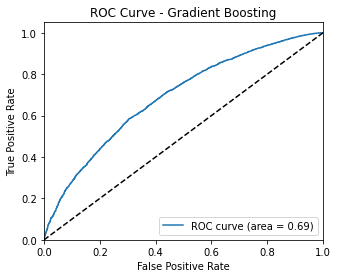

Accuracy = 0.64
Sensitivity = 0.63
Specificity = 0.65
Precision = 0.62
AUC=0.69
GINI ~=0.38


In [138]:
#Gradient Boosting
#create gradient boosting model in data train
gbt = GBTClassifier(featuresCol="Scaled_features", labelCol="readmitted",  maxIter=10)
gbt_model = gbt.fit(train)

#transfrom model to data test
gbt_result = gbt_model.transform(test)

#view id, label, prediction and probability from result of modelling
gbt_result.select( 'readmitted', 'prediction', 'probability').show(5)

#Gradient Boosting Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability",labelCol="readmitted")
gbt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
gbt_AUC  = gbt_eval.evaluate(gbt_result)
gbt_ACC  = gbt_eval2.evaluate(gbt_result, {gbt_eval2.metricName:"accuracy"})

print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_ACC)
print("AUC = %.2f" % gbt_AUC)

#ROC Grafik
PredAndLabels           = gbt_result.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

#Confusion Matrix
cm_gbt_result = gbt_result.crosstab("prediction", "readmitted")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result["1"][0]
FP = cm_gbt_result["0"][0]
TN = cm_gbt_result["0"][1]
FN = cm_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coefficient from AUC
AUC = gbt_AUC
Gini_gbt= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt)


### <font color='skyblue'> 8.5.3:Third Iteration</font> 

In [ ]:
#Gradient Boosting With Hyper-Parameter
#define gradient boosting model
gbt_hyper= GBTClassifier(featuresCol="Scaled_features", labelCol="readmitted",maxIter=10, maxDepth=12)

# Hyper-Parameter Tuning
# paramGrid_gbt = ParamGridBuilder() \
#     .addGrid(gbt_hyper.maxIter, [10])\
#     .addGrid(gbt_hyper.maxDepth, [6, 7,10]) \
#     .build()
# crossval_gbt = CrossValidator(estimator=gbt_hyper,
#                              estimatorParamMaps=paramGrid_gbt,
#                              evaluator=BinaryClassificationEvaluator(),
#                              numFolds=3)
#fit model to data train
gbt_model_hyper = gbt_hyper.fit(train)

#transfrom model to data test
gbt_result_hyper = gbt_model_hyper.transform(test)

#view id, label, prediction and probability from result of modelling
gbt_result_hyper.select( 'readmitted', 'prediction', 'probability').show(5)

#Gradient Boosting With Hyper-Parameter Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval_hyper = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="readmitted")
gbt_eval_hyper2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
gbt_hyper_AUC  = gbt_eval_hyper.evaluate(gbt_result_hyper)
gbt_hyper_ACC  = gbt_eval_hyper2.evaluate(gbt_result_hyper, {gbt_eval_hyper2.metricName:"accuracy"})


print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_hyper_ACC)
print("AUC = %.2f" % gbt_hyper_AUC)

#ROC Grafik
PredAndLabels           = gbt_result_hyper.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

#confusion Matrix
cm_gbt_result_hyper = gbt_result_hyper.crosstab("prediction", "readmitted")
cm_gbt_result_hyper = cm_gbt_result_hyper.toPandas()
cm_gbt_result_hyper

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result_hyper["1"][0]
FP = cm_gbt_result_hyper["0"][0]
TN = cm_gbt_result_hyper["0"][1]
FN = cm_gbt_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coefficient from AUC
AUC = gbt_hyper_AUC
Gini_gbt_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt_hyper)


22/10/12 09:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
22/10/12 09:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
22/10/12 09:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
22/10/12 09:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1030.6 KiB
22/10/12 09:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1060.1 KiB
22/10/12 09:50:57 WARN DAGScheduler: Broadcasting large task binary with size 1107.2 KiB
22/10/12 09:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1181.4 KiB
22/10/12 09:54:14 WARN DAGScheduler: Broadcasting large task binary with size 1163.1 KiB
22/10/12 09:54:46 WARN DAGScheduler: Broadcasting large task binary with size 1163.6 KiB
22/10/12 09:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1164.2 KiB
22/10/12 09:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1165.3 KiB
22/10/12 09:55:28 WAR

### <font color='skyblue'> 8.5.4: Fourth Iteration</font> 

In [ ]:
#Gradient Boosting With Hyper-Parameter
#define gradient boosting model
gbt_hyper= GBTClassifier(featuresCol="Scaled_features", labelCol="readmitted",maxIter=10, maxDepth=10)

# Hyper-Parameter Tuning
# paramGrid_gbt = ParamGridBuilder() \
#     .addGrid(gbt_hyper.maxIter, [10])\
#     .addGrid(gbt_hyper.maxDepth, [6, 7,10]) \
#     .build()
# crossval_gbt = CrossValidator(estimator=gbt_hyper,
#                              estimatorParamMaps=paramGrid_gbt,
#                              evaluator=BinaryClassificationEvaluator(),
#                              numFolds=3)
#fit model to data train
gbt_model_hyper = gbt_hyper.fit(train)

#transfrom model to data test
gbt_result_hyper = gbt_model_hyper.transform(test)

#view id, label, prediction and probability from result of modelling
gbt_result_hyper.select( 'readmitted', 'prediction', 'probability').show(5)

#Gradient Boosting With Hyper-Parameter Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval_hyper = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="readmitted")
gbt_eval_hyper2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
gbt_hyper_AUC  = gbt_eval_hyper.evaluate(gbt_result_hyper)
gbt_hyper_ACC  = gbt_eval_hyper2.evaluate(gbt_result_hyper, {gbt_eval_hyper2.metricName:"accuracy"})


print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_hyper_ACC)
print("AUC = %.2f" % gbt_hyper_AUC)

#ROC Grafik
PredAndLabels           = gbt_result_hyper.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

#confusion Matrix
cm_gbt_result_hyper = gbt_result_hyper.crosstab("prediction", "readmitted")
cm_gbt_result_hyper = cm_gbt_result_hyper.toPandas()
cm_gbt_result_hyper

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result_hyper["1"][0]
FP = cm_gbt_result_hyper["0"][0]
TN = cm_gbt_result_hyper["0"][1]
FN = cm_gbt_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coefficient from AUC
AUC = gbt_hyper_AUC
Gini_gbt_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt_hyper)


### <font color='skyblue'> 8.5.5 : Fifth Iteration</font> 

In [ ]:
#Gradient Boosting With Hyper-Parameter
#define gradient boosting model
gbt_hyper= GBTClassifier(featuresCol="Scaled_features", labelCol="readmitted",maxIter=10, maxDepth=6)

# Hyper-Parameter Tuning
# paramGrid_gbt = ParamGridBuilder() \
#     .addGrid(gbt_hyper.maxIter, [10])\
#     .addGrid(gbt_hyper.maxDepth, [6, 7,10]) \
#     .build()
# crossval_gbt = CrossValidator(estimator=gbt_hyper,
#                              estimatorParamMaps=paramGrid_gbt,
#                              evaluator=BinaryClassificationEvaluator(),
#                              numFolds=3)
#fit model to data train
gbt_model_hyper = gbt_hyper.fit(train)

#transfrom model to data test
gbt_result_hyper = gbt_model_hyper.transform(test)

#view id, label, prediction and probability from result of modelling
gbt_result_hyper.select( 'readmitted', 'prediction', 'probability').show(5)

#Gradient Boosting With Hyper-Parameter Evaluation
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval_hyper = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="readmitted")
gbt_eval_hyper2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="readmitted")
gbt_hyper_AUC  = gbt_eval_hyper.evaluate(gbt_result_hyper)
gbt_hyper_ACC  = gbt_eval_hyper2.evaluate(gbt_result_hyper, {gbt_eval_hyper2.metricName:"accuracy"})


print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_hyper_ACC)
print("AUC = %.2f" % gbt_hyper_AUC)

#ROC Grafik
PredAndLabels           = gbt_result_hyper.select("probability", "readmitted")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

#confusion Matrix
cm_gbt_result_hyper = gbt_result_hyper.crosstab("prediction", "readmitted")
cm_gbt_result_hyper = cm_gbt_result_hyper.toPandas()
cm_gbt_result_hyper

#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result_hyper["1"][0]
FP = cm_gbt_result_hyper["0"][0]
TN = cm_gbt_result_hyper["0"][1]
FN = cm_gbt_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

#Calculate Gini Coefficient from AUC
AUC = gbt_hyper_AUC
Gini_gbt_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt_hyper)
